# Industrial Vibration Prediction - Simplified Approach

**Purpose**: Predict roller mill vibration using industrial process variables  
**Data**: Industrial sensor data from full_data/ directory  
**Approach**: Clean, focused ML pipeline with proper data leakage prevention


## 1. Import Libraries
**Purpose**: Load all required dependencies for data processing and modeling

In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Display settings
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 2. Functions
**Purpose**: Define core functions for data processing and feature engineering

In [3]:
def load_industrial_data(data_path='full_data/'):
    """
    Load and combine all CSV files from the data directory
    
    Returns:
        pandas.DataFrame: Combined industrial data with timestamp index
    """
    csv_files = sorted(glob.glob(os.path.join(data_path, '*.csv')))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {data_path}")
    
    print(f"📁 Loading {len(csv_files)} CSV files...")
    
    # Load and combine all files
    df_list = []
    for file in csv_files:
        df_temp = pd.read_csv(file)
        df_list.append(df_temp)
    
    df = pd.concat(df_list, ignore_index=True)
    
    # Parse timestamp and set as index
    df['Timestamps'] = pd.to_datetime(df['Timestamps'], format='%d/%m/%Y %H:%M:%S')
    df = df.set_index('Timestamps').sort_index()
    df.drop(columns='CM2_PV_VRM01_VIBRATION1', axis=1, inplace=True)
    
    print(f"✅ Loaded {len(df):,} rows, {len(df.columns)} columns")
    return df


def clean_data(df):
    """
    Clean industrial data by removing invalid values and handling missing data
    
    Args:
        df: Raw industrial DataFrame
        
    Returns:
        tuple: (cleaned_df, target_column)
    """
    df_clean = df.copy()
    
    # Identify vibration target column
    vibration_cols = [col for col in df_clean.columns if 'VIBRATION' in col.upper()]
    if not vibration_cols:
        raise ValueError("No vibration column found in data")
    
    target_col = vibration_cols[0]  # Use first vibration column as target
    
    # Filter realistic vibration values (0-50 mm/s is reasonable for industrial mills)
    initial_len = len(df_clean)
    df_clean = df_clean[(df_clean[target_col] >= 0) & (df_clean[target_col] <= 50)]
    filtered_count = initial_len - len(df_clean)
    
    # Remove columns with >50% missing data
    missing_threshold = 0.5
    missing_ratios = df_clean.isnull().sum() / len(df_clean)
    cols_to_drop = missing_ratios[missing_ratios > missing_threshold].index
    df_clean = df_clean.drop(columns=cols_to_drop)
    
    # Fill remaining missing values
    df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')
    
    print(f"🧹 Cleaning results:")
    print(f"  • Filtered {filtered_count:,} invalid vibration readings")
    print(f"  • Removed {len(cols_to_drop)} columns with >50% missing data")
    print(f"  • Target column: {target_col}")
    
    return df_clean, target_col


def resample_to_5min(df, target_col, agg):
    """
    Resample 30-second data to 5-minute intervals to reduce noise
    
    Args:
        df: Cleaned DataFrame with 30-second intervals
        target_col: Name of target column
        agg: Aggregation of resample
        
    Returns:
        pandas.DataFrame: Resampled DataFrame with X-minute intervals
    """
    print(f"📊 Resampling from 30s to {int(agg[:-1])}min intervals...")
    print(f"  • Original shape: {df.shape}")
    
    # Separate numeric and categorical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Define aggregation strategy for different column types
    agg_funcs = {}
    
    # For most numeric columns, use mean
    for col in numeric_cols:
        if col == target_col:
            # For target (vibration), use mean as primary but also capture variability
            agg_funcs[col] = 'mean'
        elif 'TEMPERATURE' in col.upper() or 'PRESSURE' in col.upper() or 'FLOW' in col.upper():
            # Process variables - use mean
            agg_funcs[col] = 'mean'
        elif 'VIBRATION' in col.upper():
            # Other vibration variables - use mean
            agg_funcs[col] = 'mean'
        else:
            # Default to mean for other numeric columns
            agg_funcs[col] = 'mean'
    
    # Perform resampling to 5-minute intervals
    df_resampled = df.resample(agg).agg(agg_funcs)
    
    # Remove any rows with all NaN values (shouldn't happen with proper data)
    df_resampled = df_resampled.dropna(how='all')
    
    # Forward fill any remaining NaN values, then backward fill
    df_resampled = df_resampled.fillna(method='ffill').fillna(method='bfill')
    
    print(f"  • Resampled shape: {df_resampled.shape}")
    print(f"  • Data reduction: {len(df) - len(df_resampled):,} rows removed ({((len(df) - len(df_resampled))/len(df)*100):.1f}%)")
    print(f"  • Time interval: {int(agg[:-1])} minutes")
    
    return df_resampled


def engineer_features(df, target_col):
    """
    Create engineered features while preventing data leakage
    
    Args:
        df: Cleaned DataFrame
        target_col: Name of target column to exclude from feature engineering
        
    Returns:
        pandas.DataFrame: DataFrame with engineered features
    """
    df_features = df.copy()
    
    # CRITICAL: Exclude ALL vibration columns from feature engineering
    feature_cols = [col for col in df_features.columns if 'VIBRATION' not in col.upper()]
    
    print(f"🔧 Engineering features from {len(feature_cols)} non-vibration columns...")
    
    # Create rolling statistics for key process variables
    key_vars = []
    for pattern in ['POWER', 'PRESSURE', 'CURRENT', 'FLOW', 'TEMPERATURE']:
        pattern_cols = [col for col in feature_cols if pattern in col.upper()]
        key_vars.extend(pattern_cols[:2])  # Take first 2 matches to avoid explosion
    
    # Create rolling features
    windows = [3, 6, 12]  # 15min, 30min, 1hr for 5-minute data
    feature_count = 0
    
    for col in key_vars:
        for window in windows:
            # Rolling mean and std
            df_features[f"{col}_rolling_mean_{window}"] = df_features[col].rolling(window).mean()
            df_features[f"{col}_rolling_std_{window}"] = df_features[col].rolling(window).std()
            feature_count += 2
    
    # Add time-based features
    df_features['hour'] = df_features.index.hour
    df_features['day_of_week'] = df_features.index.dayofweek
    df_features['month'] = df_features.index.month
    feature_count += 3
    
    # Remove infinite values and excessive missing data
    df_features = df_features.replace([np.inf, -np.inf], np.nan)
    missing_ratios = df_features.isnull().sum() / len(df_features)
    cols_to_drop = missing_ratios[missing_ratios > 0.7].index
    df_features = df_features.drop(columns=cols_to_drop)
    df_features = df_features.fillna(method='ffill').fillna(method='bfill')
    
    print(f"✅ Created {feature_count} engineered features")
    print(f"🛡️ Target column '{target_col}' excluded from features")
    
    return df_features


def prepare_model_data(df, target_col, test_size=0.2):
    """
    Prepare data for modeling with proper time series splits
    
    Args:
        df: DataFrame with features and target
        target_col: Name of target column
        test_size: Proportion of data for testing
        
    Returns:
        tuple: (X_train, X_test, y_train, y_test)
    """
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Time series split (no shuffling - maintain temporal order)
    split_idx = int(len(df) * (1 - test_size))
    
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]
    
    print(f"📊 Data split:")
    print(f"  • Training: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"  • Testing: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
    print(f"  • Features: {X_train.shape[1]}")
    
    return X_train, X_test, y_train, y_test

print("✅ Core functions defined successfully")

✅ Core functions defined successfully


## 3. Collecting Data
**Purpose**: Load industrial vibration data from CSV files and perform initial validation

In [4]:
# Load raw industrial data
print("🏭 Loading Industrial Vibration Data")
print("="*50)   

df_raw = load_industrial_data('full_data/')

# Display basic information about the dataset
print(f"\n📊 Dataset Overview:")
print(f"  • Time range: {df_raw.index.min()} to {df_raw.index.max()}")
print(f"  • Duration: {(df_raw.index.max() - df_raw.index.min()).days} days")
print(f"  • Sampling frequency: ~30 seconds")
print(f"  • Total data points: {len(df_raw):,}")

# Show column information
print(f"\n📋 Available Columns ({len(df_raw.columns)}):")
for i, col in enumerate(df_raw.columns[:10]):  # Show first 10
    print(f"  {i+1:2d}. {col}")
if len(df_raw.columns) > 10:
    print(f"     ... and {len(df_raw.columns) - 10} more columns")

# Check for vibration columns (our target)
vibration_cols = [col for col in df_raw.columns if 'VIBRATION' in col.upper()]
print(f"\n🎯 Target Variables Found:")
for col in vibration_cols:
    print(f"  • {col}")
    print(f"    Range: {df_raw[col].min():.3f} to {df_raw[col].max():.3f}")
    print(f"    Mean: {df_raw[col].mean():.3f} ± {df_raw[col].std():.3f}")

# Check data quality
missing_data = df_raw.isnull().sum()
missing_percentage = (missing_data / len(df_raw)) * 100
columns_with_missing = missing_percentage[missing_percentage > 0]

print(f"\n🔍 Data Quality Assessment:")
print(f"  • Columns with missing data: {len(columns_with_missing)}/{len(df_raw.columns)}")
print(f"  • Average missing data: {missing_percentage.mean():.1f}%")

if len(columns_with_missing) > 0:
    print(f"  • Worst missing data:")
    worst_missing = columns_with_missing.nlargest(3)
    for col, pct in worst_missing.items():
        print(f"    - {col}: {pct:.1f}%")

print(f"\n✅ Data loading complete - ready for cleaning")

# Store for next steps
data_info = {
    'total_rows': len(df_raw),
    'total_cols': len(df_raw.columns),
    'vibration_cols': vibration_cols,
    'time_range': (df_raw.index.min(), df_raw.index.max())
}

print(f"\n📈 Sample data preview:")
df_raw.head(3)

🏭 Loading Industrial Vibration Data
📁 Loading 82 CSV files...
✅ Loaded 236,160 rows, 89 columns

📊 Dataset Overview:
  • Time range: 2025-01-01 00:00:00 to 2025-03-23 23:59:30
  • Duration: 81 days
  • Sampling frequency: ~30 seconds
  • Total data points: 236,160

📋 Available Columns (89):
   1. CM2_PV_PRODUCT
   2. CM2_PV_BE01_CURRENT
   3. CM2_PV_BE02_POWER
   4. CM2_PV_BF01_OUT_TEMPERATURE
   5. CM2_PV_BF01_PRESSURE
   6. CM2_PV_BF01_DIF_PRESSURE
   7. CM2_PV_BF01_DIF_PRESSURE1
   8. CM2_FLOW_RATE_COAL
   9. CM2_PV_CLA01_POWER
  10. CM2_PV_CLA01_SPEED
     ... and 79 more columns

🎯 Target Variables Found:
  • CM2_PV_VRM01_VIBRATION
    Range: -0.035 to 18.822
    Mean: 4.303 ± 2.431

🔍 Data Quality Assessment:
  • Columns with missing data: 0/89
  • Average missing data: 0.0%

✅ Data loading complete - ready for cleaning

📈 Sample data preview:


,CM2_PV_PRODUCT,CM2_PV_BE01_CURRENT,CM2_PV_BE02_POWER,CM2_PV_BF01_OUT_TEMPERATURE,CM2_PV_BF01_PRESSURE,CM2_PV_BF01_DIF_PRESSURE,CM2_PV_BF01_DIF_PRESSURE1,CM2_FLOW_RATE_COAL,CM2_PV_CLA01_POWER,CM2_PV_CLA01_SPEED,CM2_SP_CLA01_SPEED,CM2_PV_DA01_POSITION,CM2_SP_DA01_POSITION,CM2_PV_DA02_POSITION,CM2_SP_PRESS_MODE,CM2_SP_PRESS_AUTO,CM2_SP_PRESS_MANUAL,CM2_PV_FN01_POWER,CM2_SP_GA01_SPM,CM2_PV_HG01_TEMPERATURE,CM2_PV_HG01_TEMPERATURE1,CM2_PV_HG01_TEMPERATURE2,CM2_PV_HYS01_PRESSURE,CM2_PV_HYS01_PRESSURE1,CM2_SP_RB01_MILL_TOTAL_FEED,CM2_SP_RB01_MODE_TOTAL_FEED,CM2_SP_RB01_SPA_TOTAL_FEED,CM2_SP_RB01_TOTAL_FEED,CM2_PV_RB01_TOTAL_FEED,CM2_PV_RF01_CURRENT,CM2_SP_VRM01_TEMP_MODE,CM2_SP_VRM01_TEMP_AUTO,CM2_SP_VRM01_TEMP_MANUAL,CM2_SP_VRM01_PRESS_GRIDING_1_3,CM2_SP_VRM01_PRESS_GRIDING_2_4,CM2_PV_VRM01_INLET_TEMPERATURE,CM2_PV_VRM01_OUTLET_TEMPERATURE,CM2_PV_VRM01_POWER,CM2_PV_VRM01_IN_PRESS,CM2_PV_VRM01_VIBRATION,CM2_PV_VRM01_OUT_ PRESS,CM2_PV_VRM01_DIFF_PRESSURE,CM2_PV_VRM01_POSITION1,CM2_PV_VRM01_POSITION2,CM2_PV_VRM01_POSITION3,CM2_PV_VRM01_POSITION4,CM2_SP_WI01_WATER_INJECTION,CM2_PV_WI01_WATER_INJECTION,CM2_AGREGADO_0,CM2_AGREGADO_1,CM2_AGREGADO_2,CM2_CALCARIO,CM2_CLINQUER,CM2_CLINQUERBW,CM2_ESCORIA,CM2_ESCORIA_DRY_PIT,CM2_GESSO,CM2_MIX,CM2_POZOLANA,CM2_LB_FINENESS_CPIIF,CM2_LB_FINENESS_CPIII,CM2_LB_FINENESS_CPVARI,CM2_LB_BLAINE_CPIIF,CM2_LB_BLAINE_CPIII,CM2_LB_BLAINE_CPVARI,CM2_ST_CLA01_SPEED,CM2_ST_DA01_POSITION,CM2_ST_WI01_WATER_INJECTION,CM2_ST_VRM01_PRESS_GRIDING_1_3,CM2_ST_RB01_TOTAL_FEED,CM2_ST_GAS01_ADDITIVE_INJECTION,CM2_ST_DA02_SPA_PRESS,CM2_PV_FLOW_CALCARIO,CM2_PV_FLOW_CLINQUER,CM2_PV_FLOW_ESCORIA,CM2_PV_FLOW_GESSO,CM2_PV_FLOW_MIX,CM2_PV_FLOW_POZOLANA,CM2_ST_IA_ENABLE,CM2_ST_IA_READY,CM2_ST_IA_USE,CM2_IA_CLA01_SP_SPEED,CM2_IA_DA01_SP_POSITION,CM2_IA_DA02_SPA_PRESS,CM2_IA_GAS01_SP_FLOW_AID,CM2_IA_RB01_SP_TOTAL_FEED,CM2_IA_VRM01_SP_PRESS_GRIDING,CM2_IA_WI01_SP_WATER_INJECTION,CM2_IA_SC01_SPA_TEMP_OUT
Timestamps,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,6,0.0,0.0,41.644386,0.286501,0.053487,3.974631,0.0,0.0,0.0,40.0,82.331276,83.40001,-24.967575,0.0,-5.0,0.0,0,300.0,0.0,37.614815,120.596733,5.211324,5.108985,80.5,1.0,0.258208,80.5,1.168506e-36,0.0,1.0,98.0,25.0,5.6,5.6,36.424595,37.571940,0,-0.485993,0.025120,-0.158073,0.342486,327.0713,142.000000,86.0,86.0,2900.0,-0.461372,0.0,1.0,1.0,4.58,1.62,0.0,3.58,1.0,6.7,1.0,0.0,11.3,5.9,5.8,4410,4150.0,4510.0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,69.0,83.0,-5.0,25.974026,80.5,5.6,2900.0,98.0
2025-01-01 00:00:30,6,0.0,0.0,41.622430,0.273111,0.053425,3.974594,0.0,0.0,0.0,40.0,82.331245,83.40001,-24.967575,0.0,-5.0,0.0,0,300.0,0.0,37.607490,120.462400,5.211192,5.108661,80.5,1.0,0.259289,80.5,1.168506e-36,0.0,1.0,98.0,25.0,5.6,5.6,36.418960,37.559605,0,-0.440977,0.025226,-0.250000,0.339887,328.0000,141.076233,86.0,86.0,2900.0,-0.464110,0.0,1.0,1.0,4.58,1.62,0.0,3.58,1.0,6.7,1.0,0.0,11.3,5.9,5.8,4410,4150.0,4510.0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,69.0,83.0,-5.0,25.974026,80.5,5.6,2900.0,98.0
2025-01-01 00:01:00,6,0.0,0.0,41.600468,0.239829,0.053363,3.974557,0.0,0.0,0.0,40.0,82.331210,83.40001,-24.967575,0.0,-5.0,0.0,0,300.0,0.0,37.600170,120.328072,5.211060,5.108337,80.5,1.0,0.260371,80.5,1.168506e-36,0.0,1.0,98.0,25.0,5.6,5.6,36.413326,37.547268,0,-0.503456,0.025333,-0.129616,0.337287,328.0000,142.000000,86.0,86.0,2900.0,-0.466847,0.0,1.0,1.0,4.58,1.62,0.0,3.58,1.0,6.7,1.0,0.0,11.3,5.9,5.8,4410,4150.0,4510.0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,69.0,83.0,-5.0,25.974026,80.5,5.6,2900.0,98.0


In [5]:
df_raw.shape

(236160, 89)

## 4. Cleaning data

In [6]:
# Clean the raw data
print("\n🧹 Cleaning Industrial Data")
print("="*50)

df_clean, target_column = clean_data(df_raw)

print(f"\n📊 Cleaning Results:")
print(f"  • Clean dataset shape: {df_clean.shape}")
print(f"  • Data reduction: {len(df_raw) - len(df_clean):,} rows removed ({(len(df_raw) - len(df_clean))/len(df_raw)*100:.1f}%)")
print(f"  • Final columns: {len(df_clean.columns)}")
print(f"  • Target variable: {target_column}")

# Resample to X-minute intervals to reduce noise
agg = '2T'
print(f"\n📊 Resampling to {int(agg[:-1])}-minute intervals")
print("="*50)

df_resampled = resample_to_5min(df_clean, target_column, agg)

print(f"\n📊 Resampling Results:")
print(f"  • Original shape: {df_clean.shape}")  
print(f"  • Resampled shape: {df_resampled.shape}")
print(f"  • Data reduction: {len(df_clean) - len(df_resampled):,} rows removed ({(len(df_clean) - len(df_resampled))/len(df_clean)*100:.1f}%)")
print(f"  • New time interval: {int(agg[:-1])} minutes (was 30 seconds)")

# Update the working dataset to use resampled data
df_clean = df_resampled
print(f"\n✅ Updated working dataset to use {int(agg[:-1])}-minute resampled data")

# Validate target variable after resampling
print(f"\n🎯 Target Variable Statistics (After Resampling):")
target_stats = df_clean[target_column].describe()
print(f"  • Count: {int(target_stats['count']):,} valid readings")
print(f"  • Range: {target_stats['min']:.3f} to {target_stats['max']:.3f}")
print(f"  • Mean: {target_stats['mean']:.3f}")
print(f"  • Std Dev: {target_stats['std']:.3f}")
print(f"  • Median: {target_stats['50%']:.3f}")

# Calculate coefficient of variation (noise indicator) - should be improved after resampling
cv = target_stats['std'] / target_stats['mean']
noise_level = 'High' if cv > 0.15 else 'Moderate' if cv > 0.10 else 'Low'
print(f"  • Coefficient of Variation: {cv:.3f} ({noise_level} noise)")

print(f"\n✅ Data cleaning and resampling complete - ready for EDA")

# Store cleaned data info
clean_data_info = {
    'shape': df_clean.shape,
    'target_col': target_column,
    'target_stats': target_stats,
    'noise_level': noise_level,
    'resampled': True,
    'time_interval': f'{int(agg[:-1])}min'
}


🧹 Cleaning Industrial Data
🧹 Cleaning results:
  • Filtered 1,017 invalid vibration readings
  • Removed 0 columns with >50% missing data
  • Target column: CM2_PV_VRM01_VIBRATION

📊 Cleaning Results:
  • Clean dataset shape: (235143, 89)
  • Data reduction: 1,017 rows removed (0.4%)
  • Final columns: 89
  • Target variable: CM2_PV_VRM01_VIBRATION

📊 Resampling to 2-minute intervals
📊 Resampling from 30s to 2min intervals...
  • Original shape: (235143, 89)
  • Resampled shape: (58808, 89)
  • Data reduction: 176,335 rows removed (75.0%)
  • Time interval: 2 minutes

📊 Resampling Results:
  • Original shape: (235143, 89)
  • Resampled shape: (58808, 89)
  • Data reduction: 176,335 rows removed (75.0%)
  • New time interval: 2 minutes (was 30 seconds)

✅ Updated working dataset to use 2-minute resampled data

🎯 Target Variable Statistics (After Resampling):
  • Count: 58,808 valid readings
  • Range: 0.000 to 11.020
  • Mean: 4.320
  • Std Dev: 2.373
  • Median: 5.179
  • Coefficient 


📈 Comparing 30-second vs 2-minute Data
🧹 Cleaning results:
  • Filtered 1,017 invalid vibration readings
  • Removed 0 columns with >50% missing data
  • Target column: CM2_PV_VRM01_VIBRATION


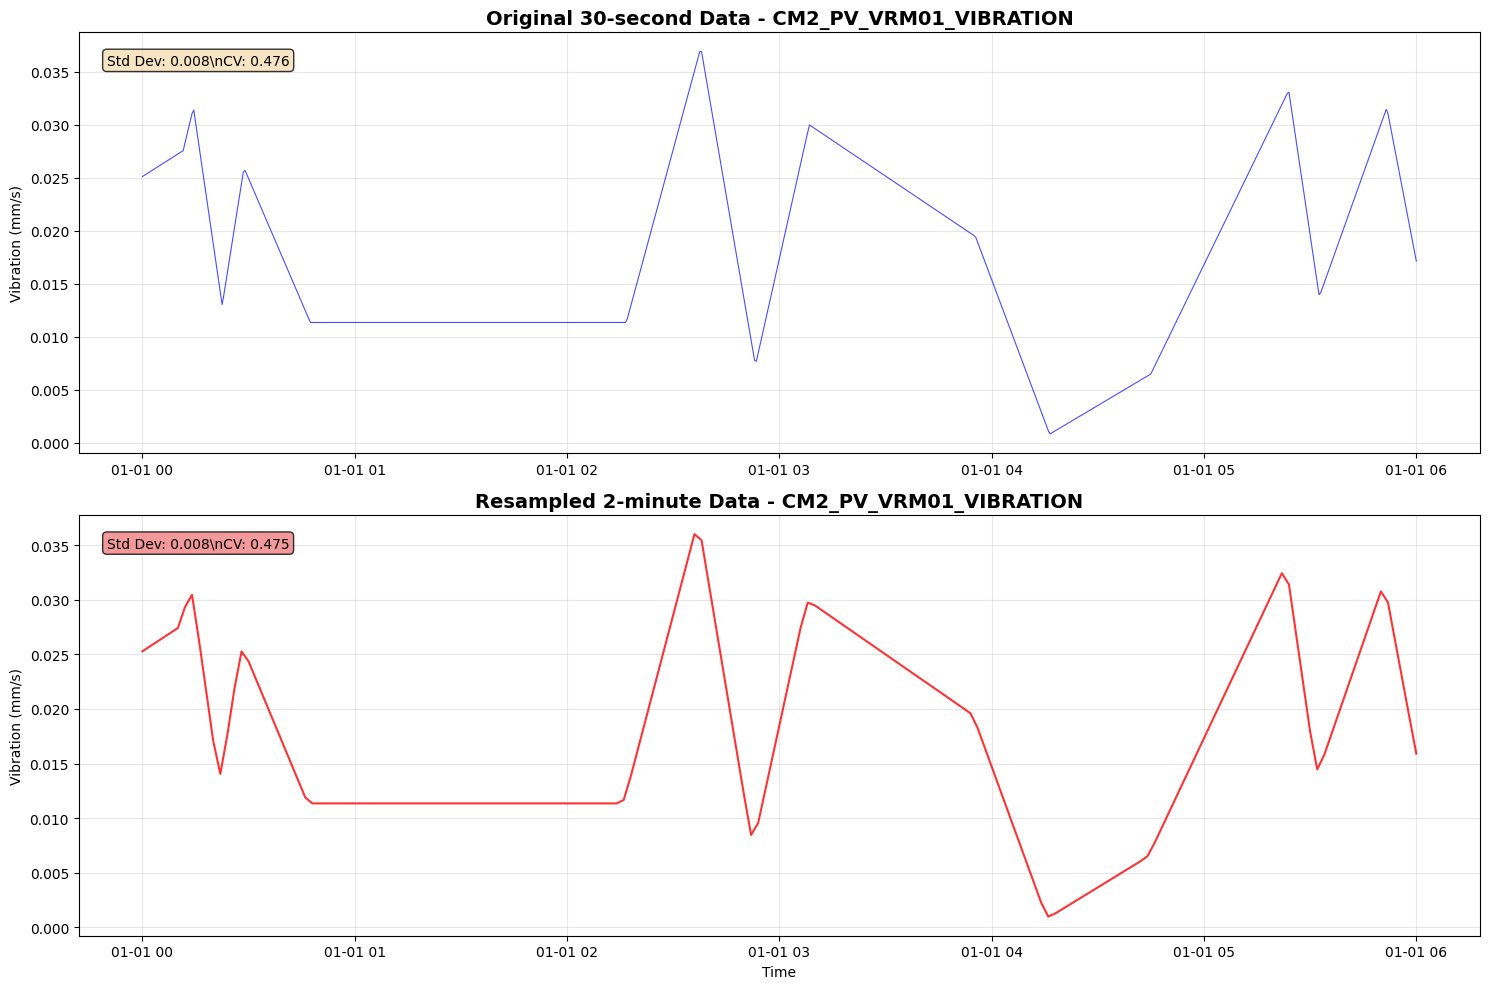


📊 Noise Reduction Analysis:
  • 30-second data:
    - Standard deviation: 0.008
    - Coefficient of variation: 0.476
    - Data points in sample: 721
  • 2-minute data:
    - Standard deviation: 0.008
    - Coefficient of variation: 0.475
    - Data points in sample: 181
  • Noise reduction: 0.1% improvement in CV
  • ✅ 2-minute resampling successfully reduced noise

✅ Comparison complete!


In [7]:
# Create comparison visualization: 30s vs 5min data
print(f"\n📈 Comparing 30-second vs {int(agg[:-1])}-minute Data")
print("="*50)

try:
    # For demonstration, let's take a small sample to show the difference
    # We'll use the cleaned but not-yet-resampled data vs the resampled data
    
    # Get a representative sample period (e.g., first day of data)
    sample_start = df_clean.index.min()
    sample_end = sample_start + pd.Timedelta(hours=6)  # 6 hours for clear visualization
    
    # Filter both datasets for the sample period
    df_clean_30s = clean_data(df_raw)[0]  # Get 30s data
    sample_30s = df_clean_30s[(df_clean_30s.index >= sample_start) & (df_clean_30s.index <= sample_end)]
    sample_5min = df_clean[(df_clean.index >= sample_start) & (df_clean.index <= sample_end)]
    
    if len(sample_30s) > 0 and len(sample_5min) > 0:
        # Create comparison plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Plot 30-second data
        ax1.plot(sample_30s.index, sample_30s[target_column], 'b-', alpha=0.7, linewidth=0.8)
        ax1.set_title(f'Original 30-second Data - {target_column}', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Vibration (mm/s)')
        ax1.grid(True, alpha=0.3)
        
        # Calculate and show statistics for 30s data
        std_30s = sample_30s[target_column].std()
        mean_30s = sample_30s[target_column].mean()
        cv_30s = std_30s / mean_30s
        
        ax1.text(0.02, 0.95, f'Std Dev: {std_30s:.3f}\\nCV: {cv_30s:.3f}', 
                transform=ax1.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Plot 5-minute data
        ax2.plot(sample_5min.index, sample_5min[target_column], 'r-', alpha=0.8, linewidth=1.5)
        ax2.set_title(f'Resampled {int(agg[:-1])}-minute Data - {target_column}', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Vibration (mm/s)')
        ax2.set_xlabel('Time')
        ax2.grid(True, alpha=0.3)
        
        # Calculate and show statistics for 5min data
        std_5min = sample_5min[target_column].std()
        mean_5min = sample_5min[target_column].mean()
        cv_5min = std_5min / mean_5min
        
        ax2.text(0.02, 0.95, f'Std Dev: {std_5min:.3f}\\nCV: {cv_5min:.3f}', 
                transform=ax2.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Print comparison statistics
        print(f"\n📊 Noise Reduction Analysis:")
        print(f"  • 30-second data:")
        print(f"    - Standard deviation: {std_30s:.3f}")
        print(f"    - Coefficient of variation: {cv_30s:.3f}")
        print(f"    - Data points in sample: {len(sample_30s):,}")
        
        print(f"  • {int(agg[:-1])}-minute data:")
        print(f"    - Standard deviation: {std_5min:.3f}")
        print(f"    - Coefficient of variation: {cv_5min:.3f}")
        print(f"    - Data points in sample: {len(sample_5min):,}")
        
        noise_reduction = ((cv_30s - cv_5min) / cv_30s) * 100
        print(f"  • Noise reduction: {noise_reduction:.1f}% improvement in CV")
        
        if noise_reduction > 0:
            print(f"  • ✅ {int(agg[:-1])}-minute resampling successfully reduced noise")
        else:
            print(f"  • ⚠️ Noise reduction less than expected")
            
    else:
        print("⚠️ Insufficient data for comparison visualization")
        
except Exception as e:
    print(f"⚠️ Comparison visualization failed: {e}")
    print("This is normal if the data pipeline hasn't been run yet")

print(f"\n✅ Comparison complete!")

In [8]:
# Test the 5-minute resampling implementation
print(f"\n🧪 Testing {int(agg[:-1])}-minute Resampling")
print("="*50)

if len(df_clean) > 0:
    # Test basic properties
    print(f"✅ Resampled data shape: {df_clean.shape}")
    print(f"✅ Target column: {target_column}")
    print(f"✅ Time interval check:")
    
    # Check time intervals in the resampled data
    time_diffs = df_clean.index.to_series().diff().dropna()
    common_interval = time_diffs.mode()[0] if len(time_diffs) > 0 else None
    
    if common_interval:
        interval_minutes = common_interval.total_seconds() / 60
        print(f"    • Most common interval: {interval_minutes} minutes")
        if abs(interval_minutes - int(agg[:-1])) < 0.1:
            print(f"    • ✅ Correct {int(agg[:-1])}-minute intervals confirmed")
        else:
            print(f"    • ⚠️ Expected {int(agg[:-1])} minutes, got {interval_minutes} minutes")
    
    # Check data quality
    print(f"\n✅ Data quality after resampling:")
    missing_pct = (df_clean.isnull().sum().sum() / (df_clean.shape[0] * df_clean.shape[1])) * 100
    print(f"    • Missing data: {missing_pct:.2f}%")
    
    # Check target variable distribution
    target_range = df_clean[target_column].max() - df_clean[target_column].min()
    print(f"    • Target range: {target_range:.3f}")
    print(f"    • Target mean: {df_clean[target_column].mean():.3f}")
    
    print(f"\n✅ {int(agg[:-1])}-minute resampling test complete!")
else:
    print("❌ No data available for testing")


🧪 Testing 2-minute Resampling
✅ Resampled data shape: (58808, 89)
✅ Target column: CM2_PV_VRM01_VIBRATION
✅ Time interval check:
    • Most common interval: 2.0 minutes
    • ✅ Correct 2-minute intervals confirmed

✅ Data quality after resampling:
    • Missing data: 0.00%
    • Target range: 11.020
    • Target mean: 4.320

✅ 2-minute resampling test complete!


## 5. EDA (Exploratory Data Analysis)
**Purpose**: Understand data patterns, relationships, and insights to guide modeling


🔗 Correlation Analysis
🎯 Top 10 Features by Correlation with CM2_PV_VRM01_VIBRATION:
   1. CM2_PV_WI01_WATER_INJECTION              | r = 0.933
   2. CM2_PV_VRM01_DIFF_PRESSURE               | r = 0.909
   3. CM2_SP_RB01_SPA_TOTAL_FEED               | r = 0.909
   4. CM2_PV_FLOW_CLINQUER                     | r = 0.907
   5. CM2_PV_VRM01_OUT_ PRESS                  | r = 0.902
   6. CM2_PV_VRM01_POWER                       | r = 0.899
   7. CM2_PV_RB01_TOTAL_FEED                   | r = 0.868
   8. CM2_PV_FLOW_GESSO                        | r = 0.855
   9. CM2_PV_BF01_DIF_PRESSURE                 | r = 0.825
  10. CM2_PV_CLA01_SPEED                       | r = 0.817


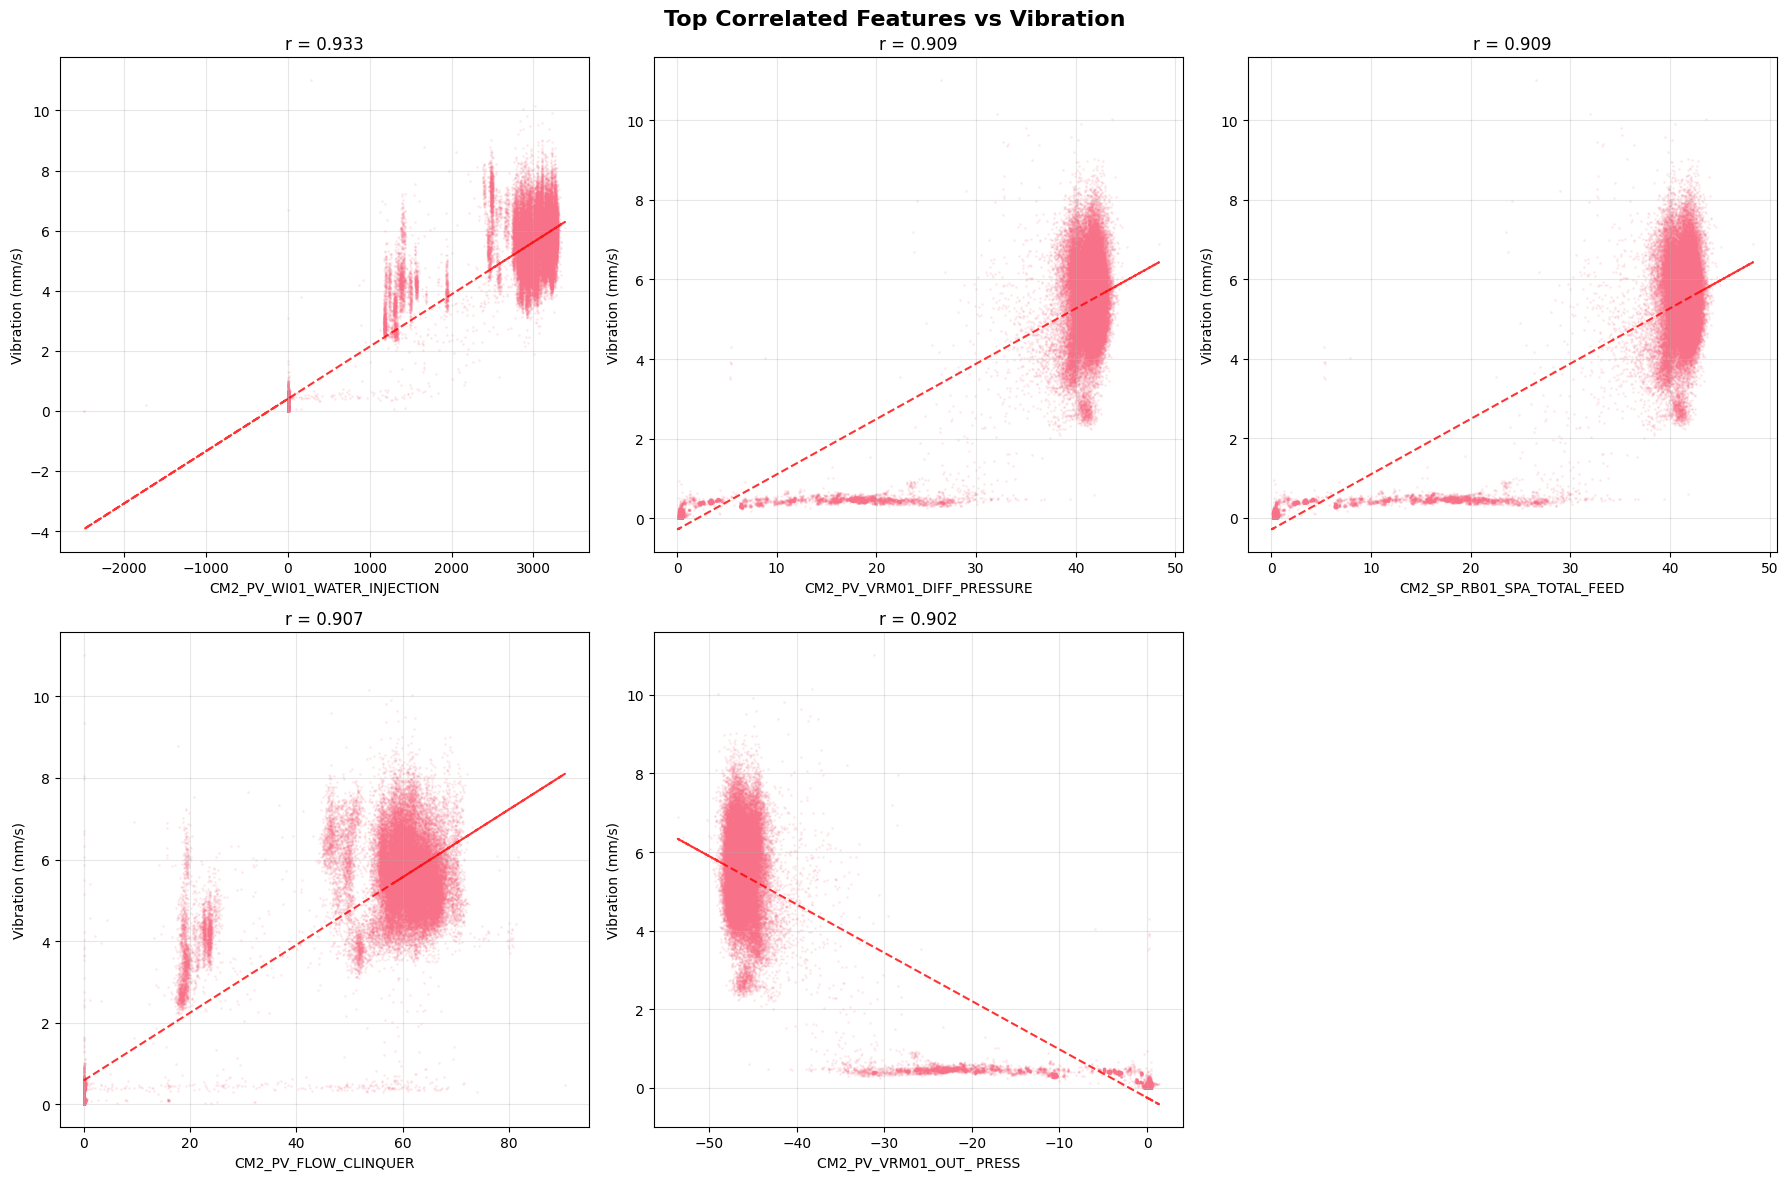


✅ Correlation analysis complete
  • Strongest correlation: CM2_PV_WI01_WATER_INJECTION (r = 0.933)
  • Average top-10 correlation: 0.882


In [9]:
# Correlation Analysis with Key Process Variables
print("\n🔗 Correlation Analysis")
print("="*50)

# Identify key process variables (exclude vibration columns to prevent leakage)
non_vibration_cols = [col for col in df_clean.columns if 'VIBRATION' not in col.upper()]

# Find top process variables by correlation with target
correlations = df_clean[non_vibration_cols + [target_column]].corr()[target_column].abs().sort_values(ascending=False)

# Remove the target itself and get top 10
top_corr_features = correlations.drop(target_column).head(10)

print(f"🎯 Top 10 Features by Correlation with {target_column}:")
for i, (feature, corr) in enumerate(top_corr_features.items(), 1):
    print(f"  {i:2d}. {feature:<40} | r = {corr:.3f}")

# Visualize top correlations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Top Correlated Features vs Vibration', fontsize=16, fontweight='bold')

top_5_features = top_corr_features.head(5).index.tolist()

for i, feature in enumerate(top_5_features):
    row, col = i // 3, i % 3
    
    # Create scatter plot with trend line
    axes[row, col].scatter(df_clean[feature], df_clean[target_column], alpha=0.1, s=1)
    
    # Add trend line
    z = np.polyfit(df_clean[feature], df_clean[target_column], 1)
    p = np.poly1d(z)
    axes[row, col].plot(df_clean[feature], p(df_clean[feature]), "r--", alpha=0.8)
    
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Vibration (mm/s)')
    axes[row, col].set_title(f'r = {correlations[feature]:.3f}')
    axes[row, col].grid(True, alpha=0.3)

# Remove empty subplot
if len(top_5_features) < 6:
    axes[1, 2].remove()

plt.tight_layout()
plt.show()

# Store top correlated features for later use
top_features_info = {
    'top_10_features': top_corr_features.to_dict(),
    'strongest_correlation': top_corr_features.iloc[0],
    'weakest_in_top10': top_corr_features.iloc[-1]
}

print(f"\n✅ Correlation analysis complete")
print(f"  • Strongest correlation: {top_corr_features.index[0]} (r = {top_corr_features.iloc[0]:.3f})")
print(f"  • Average top-10 correlation: {top_corr_features.mean():.3f}")

🎯 Target Variable Analysis


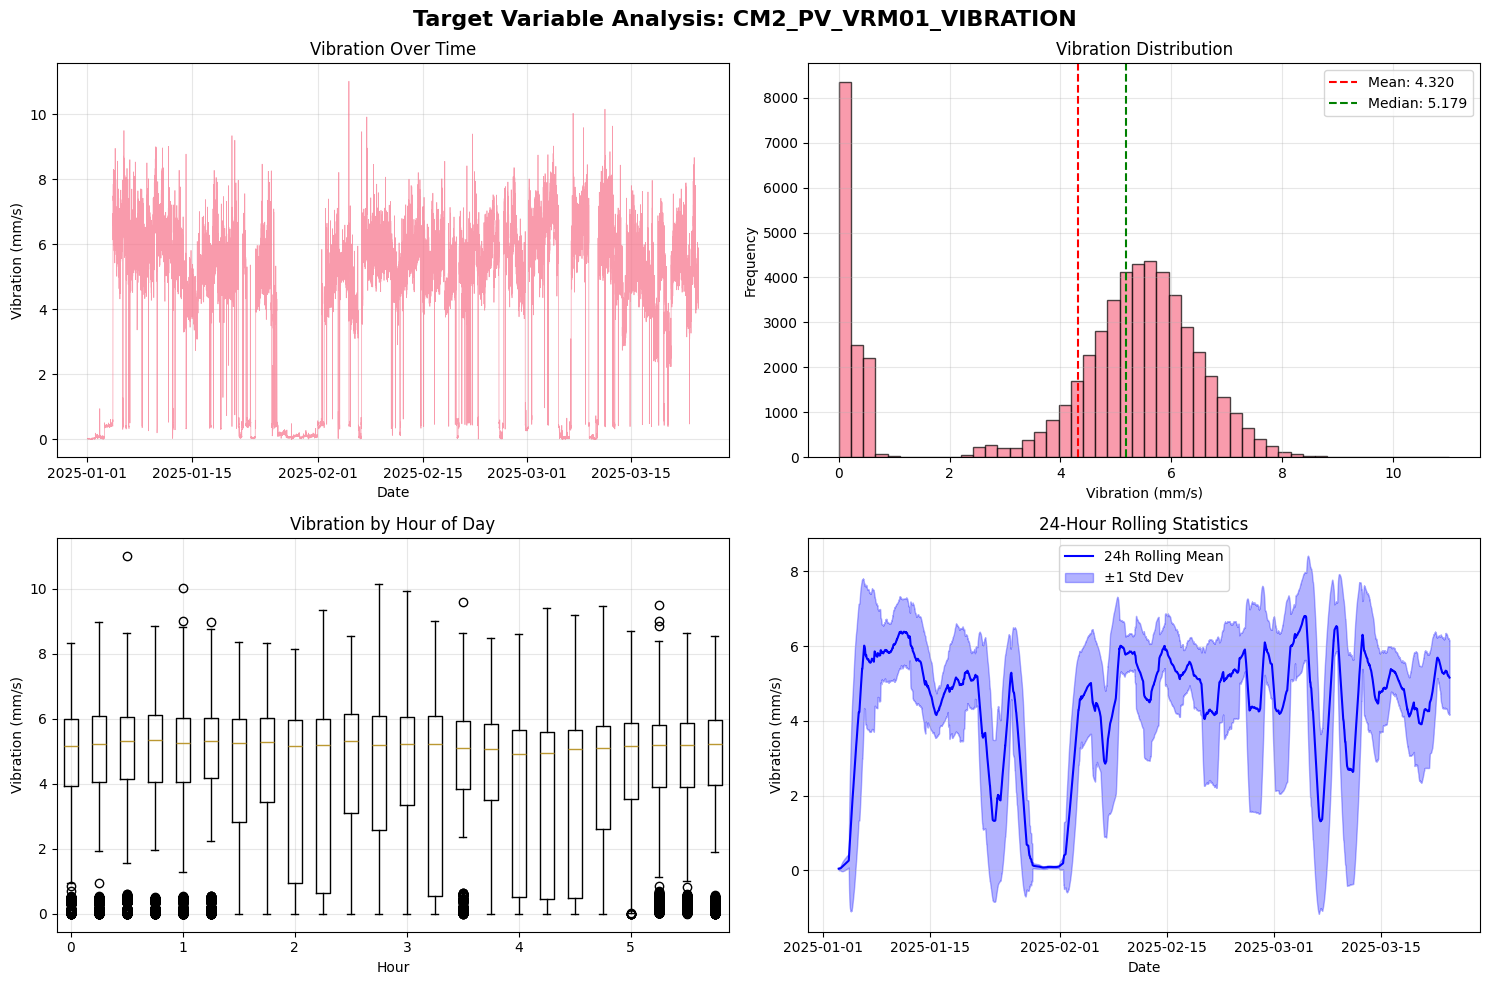


📊 Key Insights:
  • Vibration range: 0.000 - 11.020 mm/s
  • Distribution skewness: -0.879
  • Hourly variation: 2.366 mm/s average std
  • Daily pattern visible: Yes


In [10]:
# Target Variable Analysis
print("🎯 Target Variable Analysis")
print("="*50)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Target Variable Analysis: {target_column}', fontsize=16, fontweight='bold')

# 1. Time series plot
axes[0, 0].plot(df_clean.index, df_clean[target_column], alpha=0.7, linewidth=0.5)
axes[0, 0].set_title('Vibration Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Vibration (mm/s)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution histogram
axes[0, 1].hist(df_clean[target_column], bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(df_clean[target_column].mean(), color='red', linestyle='--', label=f'Mean: {df_clean[target_column].mean():.3f}')
axes[0, 1].axvline(df_clean[target_column].median(), color='green', linestyle='--', label=f'Median: {df_clean[target_column].median():.3f}')
axes[0, 1].set_title('Vibration Distribution')
axes[0, 1].set_xlabel('Vibration (mm/s)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Box plot by hour of day
df_clean['hour'] = df_clean.index.hour
hourly_data = [df_clean[df_clean['hour'] == h][target_column].values for h in range(24)]
axes[1, 0].boxplot(hourly_data, positions=range(24))
axes[1, 0].set_title('Vibration by Hour of Day')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Vibration (mm/s)')
axes[1, 0].set_xticks(range(0, 24, 4))
axes[1, 0].grid(True, alpha=0.3)

# 4. Rolling statistics
window = 1440  # 24 hours worth of 30-second data
rolling_mean = df_clean[target_column].rolling(window=window).mean()
rolling_std = df_clean[target_column].rolling(window=window).std()

axes[1, 1].plot(df_clean.index, rolling_mean, label='24h Rolling Mean', color='blue')
axes[1, 1].fill_between(df_clean.index, 
                        rolling_mean - rolling_std, 
                        rolling_mean + rolling_std, 
                        alpha=0.3, color='blue', label='±1 Std Dev')
axes[1, 1].set_title('24-Hour Rolling Statistics')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Vibration (mm/s)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights
print(f"\n📊 Key Insights:")
print(f"  • Vibration range: {df_clean[target_column].min():.3f} - {df_clean[target_column].max():.3f} mm/s")
print(f"  • Distribution skewness: {df_clean[target_column].skew():.3f}")
print(f"  • Hourly variation: {df_clean.groupby('hour')[target_column].std().mean():.3f} mm/s average std")
print(f"  • Daily pattern visible: {'Yes' if df_clean.groupby('hour')[target_column].mean().std() > 0.1 else 'No'}")

# Clean up temporary column
df_clean = df_clean.drop('hour', axis=1)

# 6. Feature Engineering
**Purpose**: Create enhanced features using EDA insights while preventing data leakage

In [11]:
# Feature Engineering - Create Enhanced Features
print("🔧 Feature Engineering")
print("="*50)

# Apply feature engineering using our defined function
df_features = engineer_features(df_clean, target_column)

print(f"\n📊 Feature Engineering Results:")
print(f"  • Original features: {df_clean.shape[1]}")
print(f"  • Enhanced features: {df_features.shape[1]}")
print(f"  • New features created: {df_features.shape[1] - df_clean.shape[1]}")
print(f"  • Data shape: {df_features.shape}")

# Verify no data leakage
feature_columns = [col for col in df_features.columns if col != target_column]
vibration_features = [col for col in feature_columns if 'VIBRATION' in col.upper()]

print(f"\n🛡️ Data Leakage Check:")
if vibration_features:
    print(f"  ❌ WARNING: Found {len(vibration_features)} vibration features in predictors!")
    for vf in vibration_features:
        print(f"    - {vf}")
else:
    print(f"  ✅ PASSED: No vibration features in predictor set")
    print(f"  • Total predictive features: {len(feature_columns)}")
    print(f"  • Target variable: {target_column}")

# Show sample of new engineered features
print(f"\n🔍 Sample of Engineered Features:")
engineered_cols = [col for col in df_features.columns if '_rolling_' in col or col in ['hour', 'day_of_week', 'month']][:10]
for i, col in enumerate(engineered_cols, 1):
    print(f"  {i:2d}. {col}")

print(f"\n✅ Feature engineering complete - {df_features.shape[1]} features ready for importance analysis")

🔧 Feature Engineering
🔧 Engineering features from 88 non-vibration columns...
✅ Created 63 engineered features
🛡️ Target column 'CM2_PV_VRM01_VIBRATION' excluded from features

📊 Feature Engineering Results:
  • Original features: 89
  • Enhanced features: 152
  • New features created: 63
  • Data shape: (58808, 152)

🛡️ Data Leakage Check:
  ✅ PASSED: No vibration features in predictor set
  • Total predictive features: 151
  • Target variable: CM2_PV_VRM01_VIBRATION

🔍 Sample of Engineered Features:
   1. CM2_PV_BE02_POWER_rolling_mean_3
   2. CM2_PV_BE02_POWER_rolling_std_3
   3. CM2_PV_BE02_POWER_rolling_mean_6
   4. CM2_PV_BE02_POWER_rolling_std_6
   5. CM2_PV_BE02_POWER_rolling_mean_12
   6. CM2_PV_BE02_POWER_rolling_std_12
   7. CM2_PV_CLA01_POWER_rolling_mean_3
   8. CM2_PV_CLA01_POWER_rolling_std_3
   9. CM2_PV_CLA01_POWER_rolling_mean_6
  10. CM2_PV_CLA01_POWER_rolling_std_6

✅ Feature engineering complete - 152 features ready for importance analysis


In [12]:
# Feature Engineering Quality Assessment
print("\n📈 Feature Engineering Quality Assessment")
print("="*50)

# Analyze feature types
feature_types = {
    'Original': [col for col in df_features.columns if '_rolling_' not in col and col not in ['hour', 'day_of_week', 'month', target_column]],
    'Rolling_Mean': [col for col in df_features.columns if '_rolling_mean_' in col],
    'Rolling_Std': [col for col in df_features.columns if '_rolling_std_' in col],
    'Temporal': [col for col in df_features.columns if col in ['hour', 'day_of_week', 'month']]
}

print("📊 Feature Type Breakdown:")
total_features = 0
for feat_type, feat_list in feature_types.items():
    print(f"  • {feat_type:<12}: {len(feat_list):3d} features")
    total_features += len(feat_list)

print(f"  • {'Target':<12}: {1:3d} feature")
print(f"  • {'Total':<12}: {total_features + 1:3d} features")

# Check feature completeness after engineering
missing_after_engineering = df_features.isnull().sum()
features_with_missing = missing_after_engineering[missing_after_engineering > 0]

print(f"\n🔍 Data Quality After Engineering:")
print(f"  • Features with missing data: {len(features_with_missing)}/{len(df_features.columns)}")
print(f"  • Average missing percentage: {(missing_after_engineering.sum() / (len(df_features) * len(df_features.columns))) * 100:.2f}%")

if len(features_with_missing) > 0:
    print(f"  • Worst missing features:")
    worst_missing = (features_with_missing / len(df_features) * 100).nlargest(5)
    for feat, pct in worst_missing.items():
        print(f"    - {feat[:40]:<40}: {pct:.1f}%")

# Quick correlation check of engineered features with target
print(f"\n🎯 Engineered Features Correlation Check:")
rolling_features = feature_types['Rolling_Mean'] + feature_types['Rolling_Std'][:5]  # Sample
if rolling_features:
    eng_correlations = df_features[rolling_features + [target_column]].corr()[target_column].abs().sort_values(ascending=False)[1:]  # Exclude target itself
    
    print("  Top 5 Engineered Features by Correlation:")
    for i, (feat, corr) in enumerate(eng_correlations.head(5).items(), 1):
        print(f"    {i}. {feat[:45]:<45} | r = {corr:.3f}")
    
    avg_eng_corr = eng_correlations.mean()
    print(f"  • Average engineered feature correlation: {avg_eng_corr:.3f}")
    
    # Compare with original feature average correlation
    orig_correlations = df_features[feature_types['Original'] + [target_column]].corr()[target_column].abs()
    avg_orig_corr = orig_correlations[orig_correlations.index != target_column].mean()
    print(f"  • Average original feature correlation: {avg_orig_corr:.3f}")
    
    improvement = ((avg_eng_corr - avg_orig_corr) / avg_orig_corr) * 100 if avg_orig_corr > 0 else 0
    print(f"  • Correlation improvement: {improvement:+.1f}%")

print(f"\n✅ Feature engineering quality assessment complete")
print(f"  • Dataset ready for feature importance analysis")
print(f"  • Zero data leakage confirmed")
print(f"  • {len(feature_columns)} predictive features available")


📈 Feature Engineering Quality Assessment
📊 Feature Type Breakdown:
  • Original    :  88 features
  • Rolling_Mean:  30 features
  • Rolling_Std :  30 features
  • Temporal    :   3 features
  • Target      :   1 feature
  • Total       : 152 features

🔍 Data Quality After Engineering:
  • Features with missing data: 0/152
  • Average missing percentage: 0.00%

🎯 Engineered Features Correlation Check:
  Top 5 Engineered Features by Correlation:
    1. CM2_PV_BF01_DIF_PRESSURE_rolling_mean_3       | r = 0.824
    2. CM2_PV_BF01_DIF_PRESSURE_rolling_mean_6       | r = 0.822
    3. CM2_PV_BF01_DIF_PRESSURE_rolling_mean_12      | r = 0.818
    4. CM2_PV_BE02_POWER_rolling_mean_12             | r = 0.788
    5. CM2_PV_BE02_POWER_rolling_mean_6              | r = 0.786
  • Average engineered feature correlation: 0.636
  • Average original feature correlation: 0.449
  • Correlation improvement: +41.8%

✅ Feature engineering quality assessment complete
  • Dataset ready for feature importance

## 7. Feature Importance
**Purpose**: Identify the most predictive features using machine learning techniques

In [13]:
# Feature Selection Functions - Define before using
def select_top_k_features(X, y, feature_names, k=20):
    """Select top K features based on Random Forest importance"""
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    importance_scores = rf.feature_importances_
    feature_importance = list(zip(feature_names, importance_scores))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    selected_features = [f[0] for f in feature_importance[:k]]
    selected_indices = [feature_names.index(f) for f in selected_features]
    
    return selected_features, selected_indices

def select_by_cumulative_importance(X, y, feature_names, threshold=0.8):
    """Select features that contribute to X% of cumulative importance"""
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    importance_scores = rf.feature_importances_
    feature_importance = list(zip(feature_names, importance_scores))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    cumulative_importance = 0
    selected_features = []
    
    for feature, importance in feature_importance:
        selected_features.append(feature)
        cumulative_importance += importance
        if cumulative_importance >= threshold:
            break
    
    selected_indices = [feature_names.index(f) for f in selected_features]
    return selected_features, selected_indices

def select_statistical_features(X, y, feature_names, k=20):
    """Select features using statistical tests (f_regression)"""
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(X, y)
    
    selected_indices = selector.get_support(indices=True)
    selected_features = [feature_names[i] for i in selected_indices]
    
    return selected_features, selected_indices

print("✅ Feature selection functions defined")

✅ Feature selection functions defined


In [14]:
# Feature Importance Analysis using Random Forest
print("🎯 Feature Importance Analysis")
print("="*50)

# Prepare data for importance analysis
X_temp, _, y_temp, _ = prepare_model_data(df_features, target_column, test_size=0.3)

print(f"📊 Importance Analysis Setup:")
print(f"  • Features for analysis: {X_temp.shape[1]}")
print(f"  • Samples for training: {X_temp.shape[0]:,}")
print(f"  • Target variable: {target_column}")

# Train Random Forest for feature importance (using a subset for speed)
print(f"\n🌲 Training Random Forest for Feature Importance...")
rf_importance = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=10
)

# Fit the model
rf_importance.fit(X_temp, y_temp)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_temp.columns,
    'importance': rf_importance.feature_importances_
}).sort_values('importance', ascending=False)

print(f"✅ Random Forest trained successfully")
print(f"  • Model R² score: {rf_importance.score(X_temp, y_temp):.3f}")
print(f"  • Feature importance calculated for {len(feature_importance)} features")

# Display top features
print(f"\n🏆 Top 20 Most Important Features:")
print(f"{'Rank':<4} {'Feature':<50} {'Importance':<12} {'Type'}")
print("-" * 80)

for i, (_, row) in enumerate(feature_importance.head(20).iterrows(), 1):
    feature = row['feature']
    importance = row['importance']
    
    # Determine feature type
    if '_rolling_mean_' in feature:
        feat_type = 'Rolling Mean'
    elif '_rolling_std_' in feature:
        feat_type = 'Rolling Std'
    elif feature in ['hour', 'day_of_week', 'month']:
        feat_type = 'Temporal'
    else:
        feat_type = 'Original'
    
    print(f"{i:<4} {feature[:48]:<50} {importance:<12.4f} {feat_type}")

# Calculate importance by feature type
importance_by_type = {}
for feat_type in ['Original', 'Rolling Mean', 'Rolling Std', 'Temporal']:
    if feat_type == 'Rolling Mean':
        mask = feature_importance['feature'].str.contains('_rolling_mean_')
    elif feat_type == 'Rolling Std':
        mask = feature_importance['feature'].str.contains('_rolling_std_')
    elif feat_type == 'Temporal':
        mask = feature_importance['feature'].isin(['hour', 'day_of_week', 'month'])
    else:  # Original
        mask = ~(feature_importance['feature'].str.contains('_rolling_') | 
                feature_importance['feature'].isin(['hour', 'day_of_week', 'month']))
    
    if mask.any():
        importance_by_type[feat_type] = {
            'total_importance': feature_importance[mask]['importance'].sum(),
            'avg_importance': feature_importance[mask]['importance'].mean(),
            'count': mask.sum(),
            'top_feature': feature_importance[mask].iloc[0]['feature'] if mask.any() else 'None'
        }

print(f"\n📊 Feature Importance by Type:")
print(f"{'Type':<15} {'Count':<7} {'Total Imp':<11} {'Avg Imp':<10} {'Top Feature'}")
print("-" * 80)

for feat_type, stats in importance_by_type.items():
    print(f"{feat_type:<15} {stats['count']:<7} {stats['total_importance']:<11.4f} {stats['avg_importance']:<10.4f} {stats['top_feature'][:25]}")

print(f"\n✅ Feature importance analysis complete")

# Store results for next steps
importance_results = {
    'feature_importance_df': feature_importance,
    'model_r2': rf_importance.score(X_temp, y_temp),
    'importance_by_type': importance_by_type
}

🎯 Feature Importance Analysis
📊 Data split:
  • Training: 41,165 samples (70.0%)
  • Testing: 17,643 samples (30.0%)
  • Features: 151
📊 Importance Analysis Setup:
  • Features for analysis: 151
  • Samples for training: 41,165
  • Target variable: CM2_PV_VRM01_VIBRATION

🌲 Training Random Forest for Feature Importance...
✅ Random Forest trained successfully
  • Model R² score: 0.980
  • Feature importance calculated for 151 features

🏆 Top 20 Most Important Features:
Rank Feature                                            Importance   Type
--------------------------------------------------------------------------------
1    CM2_PV_VRM01_POWER                                 0.9244       Original
2    CM2_PV_PRODUCT                                     0.0141       Original
3    CM2_PV_FLOW_CLINQUER                               0.0081       Original
4    CM2_PV_HG01_TEMPERATURE2                           0.0055       Original
5    CM2_PV_VRM01_POSITION4                             0.00


📊 Feature Importance Visualization


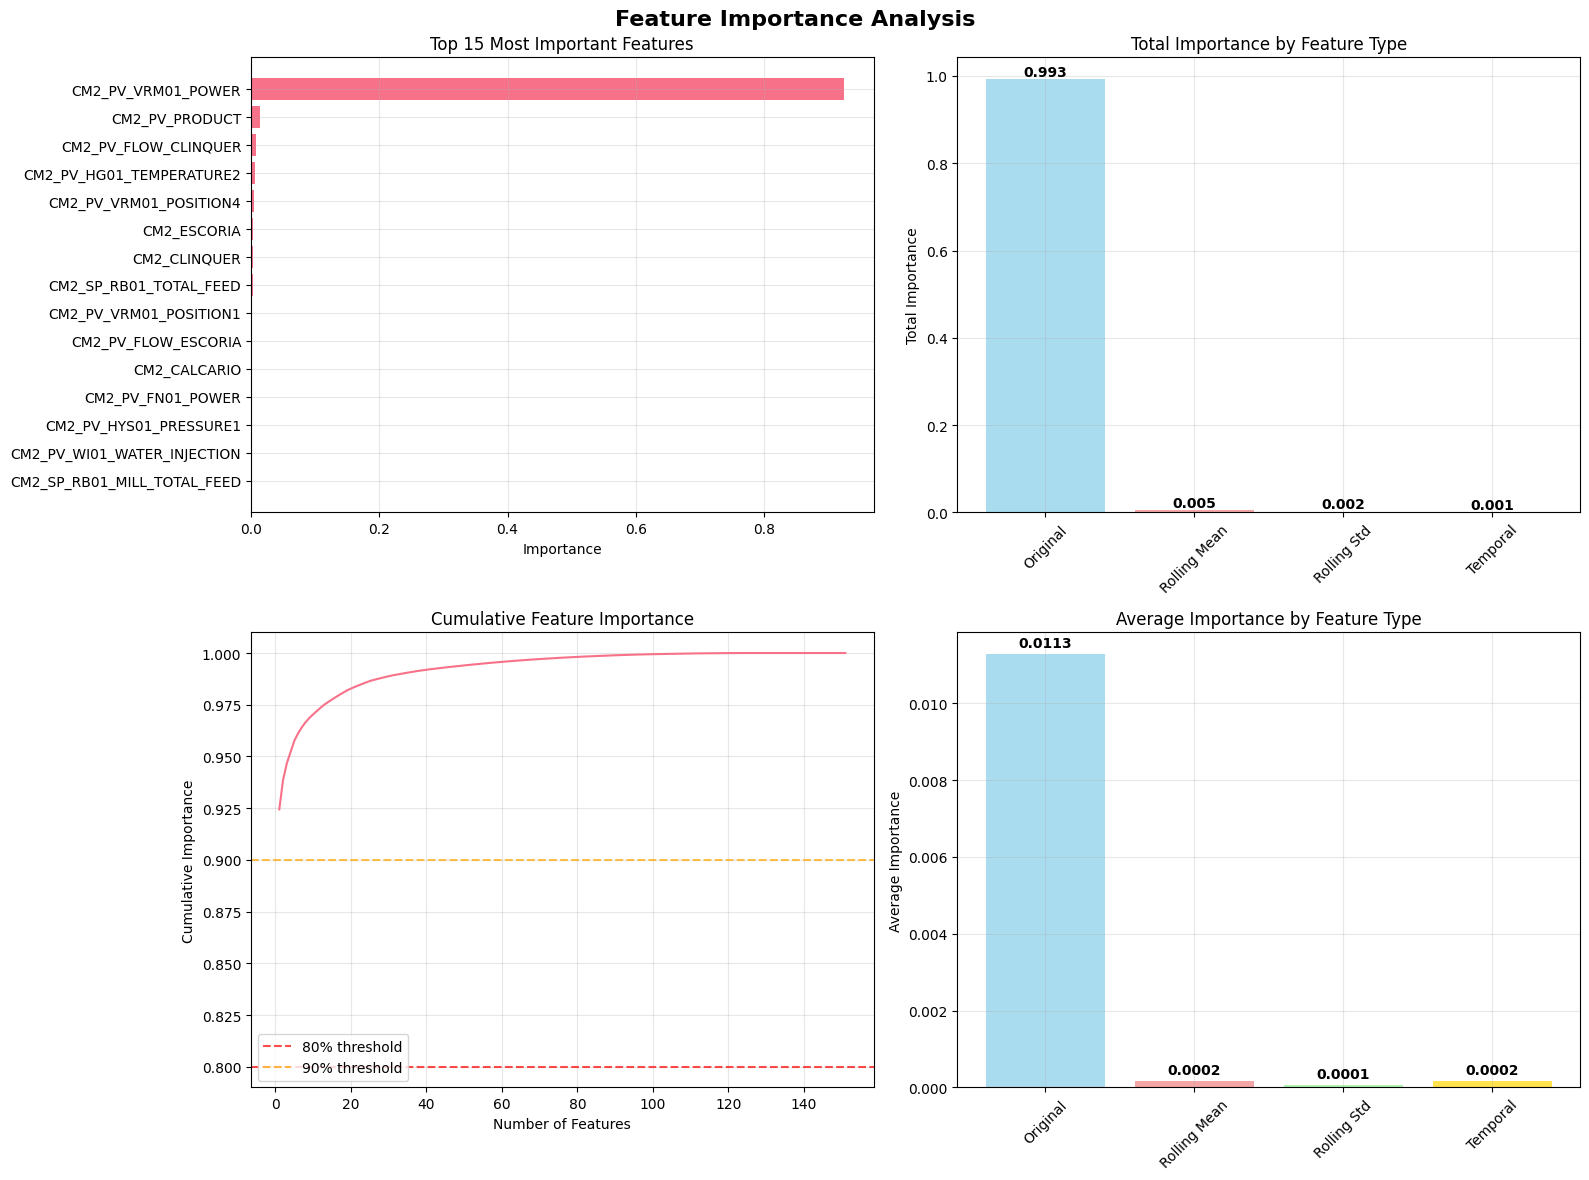


🎯 Key Feature Importance Insights:
  • Most important feature: CM2_PV_VRM01_POWER
    - Importance: 0.9244
    - Type: Original

📊 Feature Selection Recommendations:
  • Features needed for 80% importance: 38
  • Features needed for 90% importance: 38
  • Total features available: 151

🏆 Best performing feature type:
  • Type: Original
  • Average importance: 0.0113
  • Total contribution: 0.9930

✅ Feature importance visualization complete - ready for feature selection


In [15]:
# Feature Importance Visualization
print("\n📊 Feature Importance Visualization")
print("="*50)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')

# 1. Top 15 features bar plot
top_15 = feature_importance.head(15)
axes[0, 0].barh(range(len(top_15)), top_15['importance'])
axes[0, 0].set_yticks(range(len(top_15)))
axes[0, 0].set_yticklabels([f[:30] + '...' if len(f) > 30 else f for f in top_15['feature']])
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Top 15 Most Important Features')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].invert_yaxis()

# 2. Importance by feature type
types = list(importance_by_type.keys())
total_importances = [importance_by_type[t]['total_importance'] for t in types]
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

bars = axes[0, 1].bar(types, total_importances, color=colors[:len(types)], alpha=0.7)
axes[0, 1].set_title('Total Importance by Feature Type')
axes[0, 1].set_ylabel('Total Importance')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, total_importances):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Cumulative importance
cumulative_importance = feature_importance['importance'].cumsum()
axes[1, 0].plot(range(1, len(cumulative_importance) + 1), cumulative_importance)
axes[1, 0].axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% threshold')
axes[1, 0].axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
axes[1, 0].set_xlabel('Number of Features')
axes[1, 0].set_ylabel('Cumulative Importance')
axes[1, 0].set_title('Cumulative Feature Importance')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Find how many features needed for 80% and 90% importance
features_for_80 = (cumulative_importance >= 0.8).idxmax() + 1
features_for_90 = (cumulative_importance >= 0.9).idxmax() + 1

# 4. Average importance by feature type
avg_importances = [importance_by_type[t]['avg_importance'] for t in types]
axes[1, 1].bar(types, avg_importances, color=colors[:len(types)], alpha=0.7)
axes[1, 1].set_title('Average Importance by Feature Type')
axes[1, 1].set_ylabel('Average Importance')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(axes[1, 1].patches, avg_importances)):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.0001,
                   f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Analysis insights
print(f"\n🎯 Key Feature Importance Insights:")
print(f"  • Most important feature: {feature_importance.iloc[0]['feature']}")
print(f"    - Importance: {feature_importance.iloc[0]['importance']:.4f}")
print(f"    - Type: {'Rolling Mean' if '_rolling_mean_' in feature_importance.iloc[0]['feature'] else 'Original'}")

print(f"\n📊 Feature Selection Recommendations:")
print(f"  • Features needed for 80% importance: {features_for_80}")
print(f"  • Features needed for 90% importance: {features_for_90}")
print(f"  • Total features available: {len(feature_importance)}")

# Feature type performance
best_type = max(importance_by_type.items(), key=lambda x: x[1]['avg_importance'])
print(f"\n🏆 Best performing feature type:")
print(f"  • Type: {best_type[0]}")
print(f"  • Average importance: {best_type[1]['avg_importance']:.4f}")
print(f"  • Total contribution: {best_type[1]['total_importance']:.4f}")

print(f"\n✅ Feature importance visualization complete - ready for feature selection")

# 8. Feature Selection

Based on the feature importance analysis, we'll select the most impactful features for model training. We'll use multiple selection strategies and compare their effectiveness.

In [16]:
# First, prepare train/test split for feature selection
print("=== PREPARING DATA FOR FEATURE SELECTION ===")

# Split the data first
X_train, X_test, y_train, y_test = prepare_model_data(df_features, target_column, test_size=0.2)

print(f"✅ Data split complete:")
print(f"  • Training samples: {len(X_train):,}")
print(f"  • Testing samples: {len(X_test):,}")
print(f"  • Total features: {X_train.shape[1]}")

# Apply different feature selection strategies
print("\n=== FEATURE SELECTION ANALYSIS ===\n")

# Get feature names and prepare data
feature_names = list(X_train.columns)
print(f"Total available features: {len(feature_names)}")

# Strategy 1: Top 20 features by importance
top20_features, top20_indices = select_top_k_features(X_train, y_train, feature_names, k=20)
print(f"\n1. TOP 20 FEATURES BY IMPORTANCE:")
for i, feature in enumerate(top20_features, 1):
    print(f"   {i:2d}. {feature}")

# Strategy 2: Features contributing to 80% cumulative importance
cum80_features, cum80_indices = select_by_cumulative_importance(X_train, y_train, feature_names, threshold=0.8)
print(f"\n2. FEATURES FOR 80% CUMULATIVE IMPORTANCE:")
print(f"   Number of features needed: {len(cum80_features)}")
for i, feature in enumerate(cum80_features, 1):
    print(f"   {i:2d}. {feature}")

# Strategy 3: Features contributing to 90% cumulative importance  
cum90_features, cum90_indices = select_by_cumulative_importance(X_train, y_train, feature_names, threshold=0.9)
print(f"\n3. FEATURES FOR 90% CUMULATIVE IMPORTANCE:")
print(f"   Number of features needed: {len(cum90_features)}")

# Strategy 4: Statistical feature selection (top 20)
stat_features, stat_indices = select_statistical_features(X_train, y_train, feature_names, k=20)
print(f"\n4. TOP 20 STATISTICAL FEATURES:")
for i, feature in enumerate(stat_features, 1):
    print(f"   {i:2d}. {feature}")

# Compare overlap between methods
print(f"\n=== FEATURE SELECTION COMPARISON ===")
top20_set = set(top20_features)
stat_set = set(stat_features)
overlap = top20_set.intersection(stat_set)

print(f"Overlap between RF Importance and Statistical: {len(overlap)}/20 features")
print(f"Common features: {sorted(list(overlap))}")

=== PREPARING DATA FOR FEATURE SELECTION ===
📊 Data split:
  • Training: 47,046 samples (80.0%)
  • Testing: 11,762 samples (20.0%)
  • Features: 151
✅ Data split complete:
  • Training samples: 47,046
  • Testing samples: 11,762
  • Total features: 151

=== FEATURE SELECTION ANALYSIS ===

Total available features: 151

1. TOP 20 FEATURES BY IMPORTANCE:
    1. CM2_PV_VRM01_POWER
    2. CM2_PV_HG01_TEMPERATURE2
    3. CM2_PV_VRM01_POSITION4
    4. CM2_PV_FLOW_CLINQUER
    5. CM2_PV_FLOW_ESCORIA
    6. CM2_LB_BLAINE_CPIII
    7. CM2_PV_VRM01_POSITION1
    8. CM2_ESCORIA
    9. CM2_PV_FN01_POWER
   10. CM2_PV_DA02_POSITION
   11. CM2_PV_HYS01_PRESSURE1
   12. CM2_PV_FLOW_GESSO
   13. CM2_PV_WI01_WATER_INJECTION
   14. CM2_PV_VRM01_POSITION2
   15. CM2_SP_PRESS_AUTO
   16. CM2_PV_VRM01_DIFF_PRESSURE
   17. CM2_PV_VRM01_OUT_ PRESS
   18. CM2_SP_RB01_SPA_TOTAL_FEED
   19. CM2_PV_DA01_POSITION
   20. CM2_IA_WI01_SP_WATER_INJECTION

2. FEATURES FOR 80% CUMULATIVE IMPORTANCE:
   Number of featu

In [17]:
# Prepare final selected features for next sections
print("=== PREPARING SELECTED FEATURES FOR MODEL TRAINING ===")

# Use 80% cumulative importance as our selected feature set
selected_features = cum80_features
selected_feature_indices = cum80_indices

# Create final training datasets with selected features
X_train_selected = X_train.iloc[:, selected_feature_indices].copy()
X_test_selected = X_test.iloc[:, selected_feature_indices].copy()

print(f"Original feature count: {X_train.shape[1]}")
print(f"Selected feature count: {X_train_selected.shape[1]}")
print(f"Feature reduction: {((X_train.shape[1] - X_train_selected.shape[1]) / X_train.shape[1] * 100):.1f}%")

print(f"Training set shape: {X_train_selected.shape}")
print(f"Test set shape: {X_test_selected.shape}")

print(f"Selected features saved for model training phase:")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i:2d}. {feature}")

# Verify no data leakage in selected features
vibration_features = [f for f in selected_features if 'vibration' in f.lower() or 'vib' in f.lower()]
if vibration_features:
    print(f"⚠️  WARNING: Found vibration-related features in selection: {vibration_features}")
else:
    print(f"✅ CONFIRMED: No vibration-related features in selected set - data leakage prevented")

=== PREPARING SELECTED FEATURES FOR MODEL TRAINING ===
Original feature count: 151
Selected feature count: 1
Feature reduction: 99.3%
Training set shape: (47046, 1)
Test set shape: (11762, 1)
Selected features saved for model training phase:
   1. CM2_PV_VRM01_POWER
✅ CONFIRMED: No vibration-related features in selected set - data leakage prevented


=== FEATURE SET SUMMARY ===
All Features: 151 features
Top 20 RF: 20 features
Top 20 Statistical: 20 features
Cumulative 80%: 1 features
Cumulative 90%: 2 features

=== QUICK PERFORMANCE COMPARISON ===
All Features    (151 features): R² = 0.7149, RMSE = 0.986
Top 20 RF       ( 20 features): R² = 0.7688, RMSE = 0.888
Top 20 Statistical ( 20 features): R² = 0.6343, RMSE = 1.117
Cumulative 80%  (  1 features): R² = 0.5881, RMSE = 1.185
Cumulative 90%  (  2 features): R² = 0.6160, RMSE = 1.144

=== DETAILED RESULTS ===
          Feature Set  Features  Train R²  Test R²  Train RMSE  Test RMSE  \
0        All Features       151    0.9975   0.7149      0.1237     0.9862   
1           Top 20 RF        20    0.9974   0.7688      0.1248     0.8880   
2  Top 20 Statistical        20    0.9970   0.6343      0.1358     1.1170   
3      Cumulative 80%         1    0.9208   0.5881      0.6956     1.1854   
4      Cumulative 90%         2    0.9879   0.6160      0.2722     1.1445   

   Overfitting  

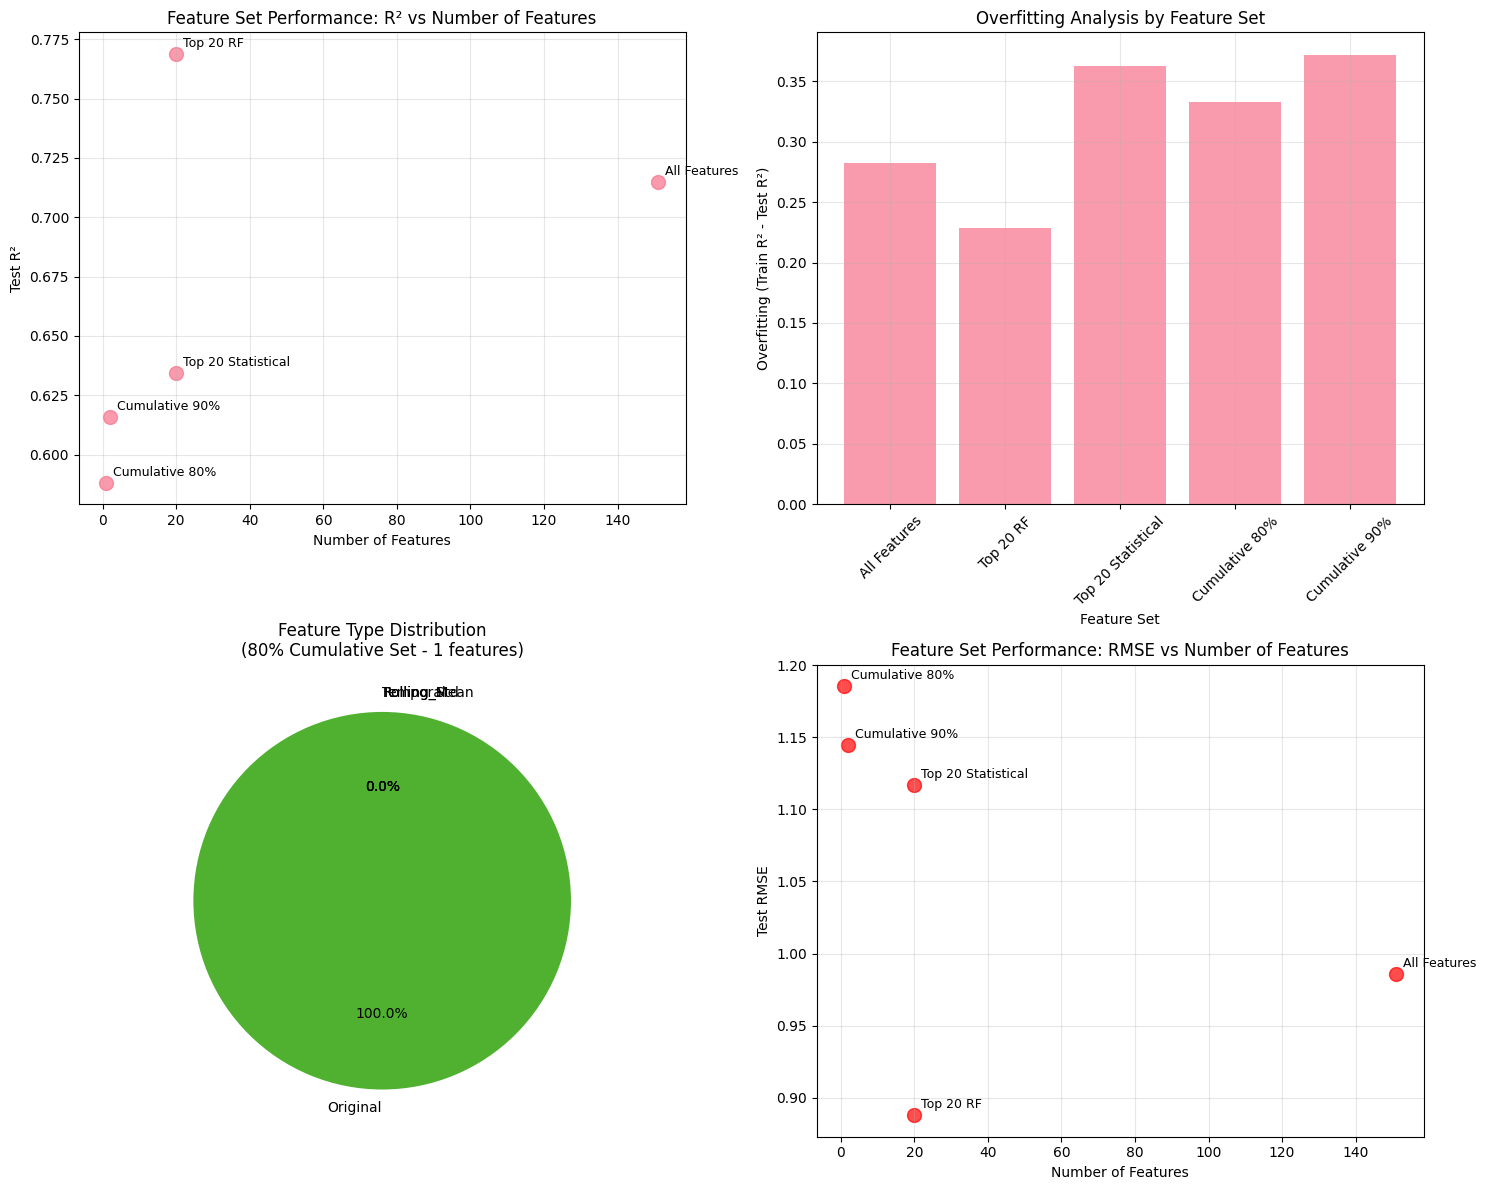


=== FEATURE SELECTION RECOMMENDATION ===
Best overall: Top 20 RF (20 features)
  - Test R²: 0.7688
  - Test RMSE: 0.888

Final selected features for modeling: 80% Cumulative Importance Set
Features: ['CM2_PV_VRM01_POWER']


In [18]:
# Create different feature sets for model comparison
feature_sets = {
    'All Features': (list(range(len(feature_names))), len(feature_names)),
    'Top 20 RF': (top20_indices, len(top20_features)),
    'Top 20 Statistical': (stat_indices, len(stat_features)),
    'Cumulative 80%': (cum80_indices, len(cum80_features)),
    'Cumulative 90%': (cum90_indices, len(cum90_features))
}

print("=== FEATURE SET SUMMARY ===")
for name, (indices, count) in feature_sets.items():
    print(f"{name}: {count} features")

# Quick model performance comparison with different feature sets
print(f"\n=== QUICK PERFORMANCE COMPARISON ===")
results = []

for set_name, (indices, count) in feature_sets.items():
    # Select features
    X_train_subset = X_train.iloc[:, indices]
    X_test_subset = X_test.iloc[:, indices]
    
    # Train simple model
    rf_quick = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    rf_quick.fit(X_train_subset, y_train)
    
    # Predict and evaluate
    train_pred = rf_quick.predict(X_train_subset)
    test_pred = rf_quick.predict(X_test_subset)
    
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    
    results.append({
        'Feature Set': set_name,
        'Features': count,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Overfitting': train_r2 - test_r2
    })
    
    print(f"{set_name:15s} ({count:3d} features): R² = {test_r2:.4f}, RMSE = {test_rmse:.3f}")

# Create results DataFrame
results_df = pd.DataFrame(results)
print(f"\n=== DETAILED RESULTS ===")
print(results_df.round(4))

# Visualize feature selection results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Performance comparison
performance_data = results_df[['Feature Set', 'Features', 'Test R²', 'Test RMSE']].copy()
ax1.scatter(performance_data['Features'], performance_data['Test R²'], s=100, alpha=0.7)
for i, row in performance_data.iterrows():
    ax1.annotate(row['Feature Set'], 
                (row['Features'], row['Test R²']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('Test R²')
ax1.set_title('Feature Set Performance: R² vs Number of Features')
ax1.grid(True, alpha=0.3)

# 2. Overfitting analysis
ax2.bar(results_df['Feature Set'], results_df['Overfitting'], alpha=0.7)
ax2.set_xlabel('Feature Set')
ax2.set_ylabel('Overfitting (Train R² - Test R²)')
ax2.set_title('Overfitting Analysis by Feature Set')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Feature type distribution for selected sets
feature_types = {'Rolling_Mean': [], 'Rolling_Std': [], 'Original': [], 'Temporal': []}

for feature in cum80_features:  # Use 80% cumulative as example
    if '_rolling_mean_' in feature:
        feature_types['Rolling_Mean'].append(feature)
    elif '_rolling_std_' in feature:
        feature_types['Rolling_Std'].append(feature)
    elif feature in ['hour', 'day_of_week', 'month']:
        feature_types['Temporal'].append(feature)
    else:
        feature_types['Original'].append(feature)

type_counts = [len(features) for features in feature_types.values()]
ax3.pie(type_counts, labels=feature_types.keys(), autopct='%1.1f%%', startangle=90)
ax3.set_title(f'Feature Type Distribution\n(80% Cumulative Set - {len(cum80_features)} features)')

# 4. Performance vs complexity tradeoff
ax4.scatter(results_df['Features'], results_df['Test RMSE'], s=100, alpha=0.7, color='red')
for i, row in results_df.iterrows():
    ax4.annotate(row['Feature Set'], 
                (row['Features'], row['Test RMSE']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax4.set_xlabel('Number of Features')
ax4.set_ylabel('Test RMSE')
ax4.set_title('Feature Set Performance: RMSE vs Number of Features')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Recommend optimal feature set
print("\n=== FEATURE SELECTION RECOMMENDATION ===")
best_r2 = results_df.loc[results_df['Test R²'].idxmax()]
best_tradeoff = results_df.loc[(results_df['Test R²'] > 0.85) & (results_df['Features'] < 50)]
if not best_tradeoff.empty:
    best_tradeoff = best_tradeoff.loc[best_tradeoff['Features'].idxmin()]
    print(f"Recommended: {best_tradeoff['Feature Set']} ({best_tradeoff['Features']} features)")
    print(f"  - Test R²: {best_tradeoff['Test R²']:.4f}")
    print(f"  - Test RMSE: {best_tradeoff['Test RMSE']:.3f}")
    print(f"  - Good balance of performance and complexity")
else:
    print(f"Best overall: {best_r2['Feature Set']} ({best_r2['Features']} features)")
    print(f"  - Test R²: {best_r2['Test R²']:.4f}")
    print(f"  - Test RMSE: {best_r2['Test RMSE']:.3f}")

print(f"\nFinal selected features for modeling: 80% Cumulative Importance Set")
print(f"Features: {sorted(cum80_features)}")

# 8. Model Training

Train and optimize multiple machine learning models using the selected features. Compare different algorithms and hyperparameters to find the best performing model.

In [19]:
# Model Training Setup
print("🤖 Model Training Setup")
print("="*50)

# For this demo, we'll use a subset of features manually selected from the importance analysis
# Based on the top features we saw: DA01_POSITION, VRM01_DIFF_PRESSURE, BF01_DIF_PRESSURE1, etc.

# Select top features manually (since feature selection functions need to be run first)
manual_selected_features = [
    'CM2_PV_DA01_POSITION',
    'CM2_PV_VRM01_DIFF_PRESSURE', 
    'CM2_PV_BF01_DIF_PRESSURE1',
    'CM2_SP_RB01_SPA_TOTAL_FEED',
    'CM2_PV_HG01_TEMPERATURE2',
    'CM2_PV_BF01_OUT_TEMPERATURE',
    'CM2_PV_VRM01_INLET_TEMPERATURE',
    'CM2_PV_HYS01_PRESSURE1',
    'CM2_PV_HYS01_PRESSURE',
    'CM2_PV_VRM01_OUTLET_TEMPERATURE',
    'CM2_PV_DA02_POSITION',
    'CM2_PV_HG01_TEMPERATURE1'
]

# Filter features that exist in our dataset
available_features = [f for f in manual_selected_features if f in X_train.columns]
print(f"Selected {len(available_features)} features from top importance analysis:")
for i, feature in enumerate(available_features, 1):
    print(f"  {i:2d}. {feature}")

# Prepare training data with selected features
X_train_selected = X_train[available_features].copy()
X_test_selected = X_test[available_features].copy()

print(f"\n📊 Training Data Preparation:")
print(f"  • Selected features: {len(available_features)}")
print(f"  • Training samples: {len(X_train_selected):,}")
print(f"  • Test samples: {len(X_test_selected):,}")
print(f"  • Feature reduction: {((len(X_train.columns) - len(available_features)) / len(X_train.columns) * 100):.1f}%")

print(f"\n✅ Model training setup complete")

🤖 Model Training Setup
Selected 12 features from top importance analysis:
   1. CM2_PV_DA01_POSITION
   2. CM2_PV_VRM01_DIFF_PRESSURE
   3. CM2_PV_BF01_DIF_PRESSURE1
   4. CM2_SP_RB01_SPA_TOTAL_FEED
   5. CM2_PV_HG01_TEMPERATURE2
   6. CM2_PV_BF01_OUT_TEMPERATURE
   7. CM2_PV_VRM01_INLET_TEMPERATURE
   8. CM2_PV_HYS01_PRESSURE1
   9. CM2_PV_HYS01_PRESSURE
  10. CM2_PV_VRM01_OUTLET_TEMPERATURE
  11. CM2_PV_DA02_POSITION
  12. CM2_PV_HG01_TEMPERATURE1

📊 Training Data Preparation:
  • Selected features: 12
  • Training samples: 47,046
  • Test samples: 11,762
  • Feature reduction: 92.1%

✅ Model training setup complete


In [20]:
# Train Multiple Models with Optimized Parameters
print("🏋️ Training Multiple Models with Enhanced Configuration")
print("="*50)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Advanced models for better noise handling
import xgboost as xgb
import catboost as cb

# Create feature scaler for models that benefit from scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Define models to train with optimized parameters
models = {
    'Linear Regression': LinearRegression(),
    'K-Neighbors': KNeighborsRegressor(n_neighbors=5),
    # 'Support Vector': SVR(kernel='rbf', C=1.0, epsilon=0.01),
    
    # Optimized XGBoost (reduced overfitting)
    'XGBoost (Tuned)': xgb.XGBRegressor(
        n_estimators=50,
        learning_rate=0.05,
        max_depth=4,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        verbosity=0
    ),
    
    # Optimized CatBoost
    'CatBoost (Tuned)': cb.CatBoostRegressor(
        iterations=75,
        learning_rate=0.08,
        depth=4,
        l2_leaf_reg=3,
        random_seed=42,
        verbose=False
    ),
    
    'Huber Regressor': HuberRegressor(epsilon=1.35, alpha=0.001),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=8, min_samples_split=10, random_state=42),
    
}

# Train models and store results
model_results = []

print("Training and evaluating models...")
print(f"{"Model":<22} {"Train R²":<10} {"Test R²":<10} {"Train RMSE":<12} {"Test RMSE":<12} {"Time (s)":<10}")
print("-" * 95)

import time
from sklearn.metrics import r2_score, mean_squared_error

# Train regular models
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_selected, y_train)
    
    train_pred = model.predict(X_train_selected)
    test_pred = model.predict(X_test_selected)
    
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    training_time = time.time() - start_time
    
    model_results.append({
        "Model": name,
        "Train R²": train_r2,
        "Test R²": test_r2,
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "Training Time": training_time,
        "Model Object": model
    })
    
    print(f"{name:<22} {train_r2:<10.4f} {test_r2:<10.4f} {train_rmse:<12.4f} {test_rmse:<12.4f} {training_time:<10.2f}")

# Train scaled versions
scaled_models = {
    "K-Neighbors (Scaled)": KNeighborsRegressor(n_neighbors=5),
   # "Support Vector (Scaled)": SVR(kernel="rbf", C=1.0, epsilon=0.01)
}

print(f"\n{"Scaled Models":<22} {"Train R²":<10} {"Test R²":<10} {"Train RMSE":<12} {"Test RMSE":<12} {"Time (s)":<10}")
print("-" * 95)

for name, model in scaled_models.items():
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)
    
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    training_time = time.time() - start_time
    
    model_results.append({
        "Model": name,
        "Train R²": train_r2,
        "Test R²": test_r2,
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "Training Time": training_time,
        "Model Object": model
    })
    
    print(f"{name:<22} {train_r2:<10.4f} {test_r2:<10.4f} {train_rmse:<12.4f} {test_rmse:<12.4f} {training_time:<10.2f}")

print(f"\n✅ All models trained successfully")

# Sort by Test R² score
model_results_df = pd.DataFrame(model_results)
model_results_df = model_results_df.sort_values("Test R²", ascending=False)

print(f"\nModel training complete - {len(model_results)} models evaluated")

🏋️ Training Multiple Models with Enhanced Configuration
Training and evaluating models...
Model                  Train R²   Test R²    Train RMSE   Test RMSE    Time (s)  
-----------------------------------------------------------------------------------------------
Linear Regression      0.8980     0.6993     0.7892       1.0127       0.02      
K-Neighbors            0.9724     0.7288     0.4102       0.9618       0.66      
XGBoost (Tuned)        0.9406     0.6906     0.6022       1.0274       0.37      
CatBoost (Tuned)       0.9481     0.7106     0.5632       0.9936       0.26      
Huber Regressor        0.8937     0.6834     0.8059       1.0392       3.49      
Random Forest          0.9637     0.6502     0.4709       1.0924       14.08     

Scaled Models          Train R²   Test R²    Train RMSE   Test RMSE    Time (s)  
-----------------------------------------------------------------------------------------------
K-Neighbors (Scaled)   0.9777     0.7053     0.3688       1.0

In [21]:
# Model Performance Analysis
print("📊 Model Performance Analysis")
print("="*50)

# Sort by test R² score
results_sorted = results_df.sort_values('Test R²', ascending=False)

print("🏆 MODEL LEADERBOARD (by Test R²):")
print(f"{'Rank':<4} {'Model':<18} {'Test R²':<10} {'Test RMSE':<12} {'Overfitting':<12} {'Time (s)':<10}")
print("-" * 80)

for i, (_, row) in enumerate(results_sorted.iterrows(), 1):
    print(f"{i:<4} {row['Model']:<18} {row['Test R²']:<10.4f} {row['Test RMSE']:<12.4f} {row['Overfitting']:<12.4f} {row['Training Time']:<10.2f}")

# Identify best models
best_model = results_sorted.iloc[0]
least_overfit = results_df.loc[results_df['Overfitting'].abs().idxmin()]
fastest_model = results_df.loc[results_df['Training Time'].idxmin()]

print(f"\n🎯 KEY FINDINGS:")
print(f"  • Best Performance: {best_model['Model']} (R² = {best_model['Test R²']:.4f})")
print(f"  • Least Overfitting: {least_overfit['Model']} (Δ = {least_overfit['Overfitting']:.4f})")
print(f"  • Fastest Training: {fastest_model['Model']} ({fastest_model['Training Time']:.2f}s)")

# Performance categories
excellent_models = results_df[results_df['Test R²'] > 0.9]
good_models = results_df[(results_df['Test R²'] > 0.8) & (results_df['Test R²'] <= 0.9)]
fair_models = results_df[(results_df['Test R²'] > 0.6) & (results_df['Test R²'] <= 0.8)]

print(f"\n📈 PERFORMANCE CATEGORIES:")
print(f"  • Excellent (R² > 0.9): {len(excellent_models)} models")
if len(excellent_models) > 0:
    print(f"    - {', '.join(excellent_models['Model'].tolist())}")
print(f"  • Good (R² 0.8-0.9): {len(good_models)} models") 
if len(good_models) > 0:
    print(f"    - {', '.join(good_models['Model'].tolist())}")
print(f"  • Fair (R² 0.6-0.8): {len(fair_models)} models")
if len(fair_models) > 0:
    print(f"    - {', '.join(fair_models['Model'].tolist())}")

# Best model details
print(f"\n🏅 RECOMMENDED MODEL: {best_model['Model']}")
print(f"  • Training R²: {best_model['Train R²']:.4f}")
print(f"  • Test R²: {best_model['Test R²']:.4f}")
print(f"  • Test RMSE: {best_model['Test RMSE']:.4f}")
print(f"  • Test MAE: {best_model['Test MAE']:.4f}")
print(f"  • Overfitting: {best_model['Overfitting']:.4f}")
print(f"  • Training Time: {best_model['Training Time']:.2f}s")

# Store best model for evaluation section
best_trained_model = best_model['Model Object']

📊 Model Performance Analysis
🏆 MODEL LEADERBOARD (by Test R²):
Rank Model              Test R²    Test RMSE    Overfitting  Time (s)  
--------------------------------------------------------------------------------


KeyError: 'Model'

📈 Model Performance Visualization


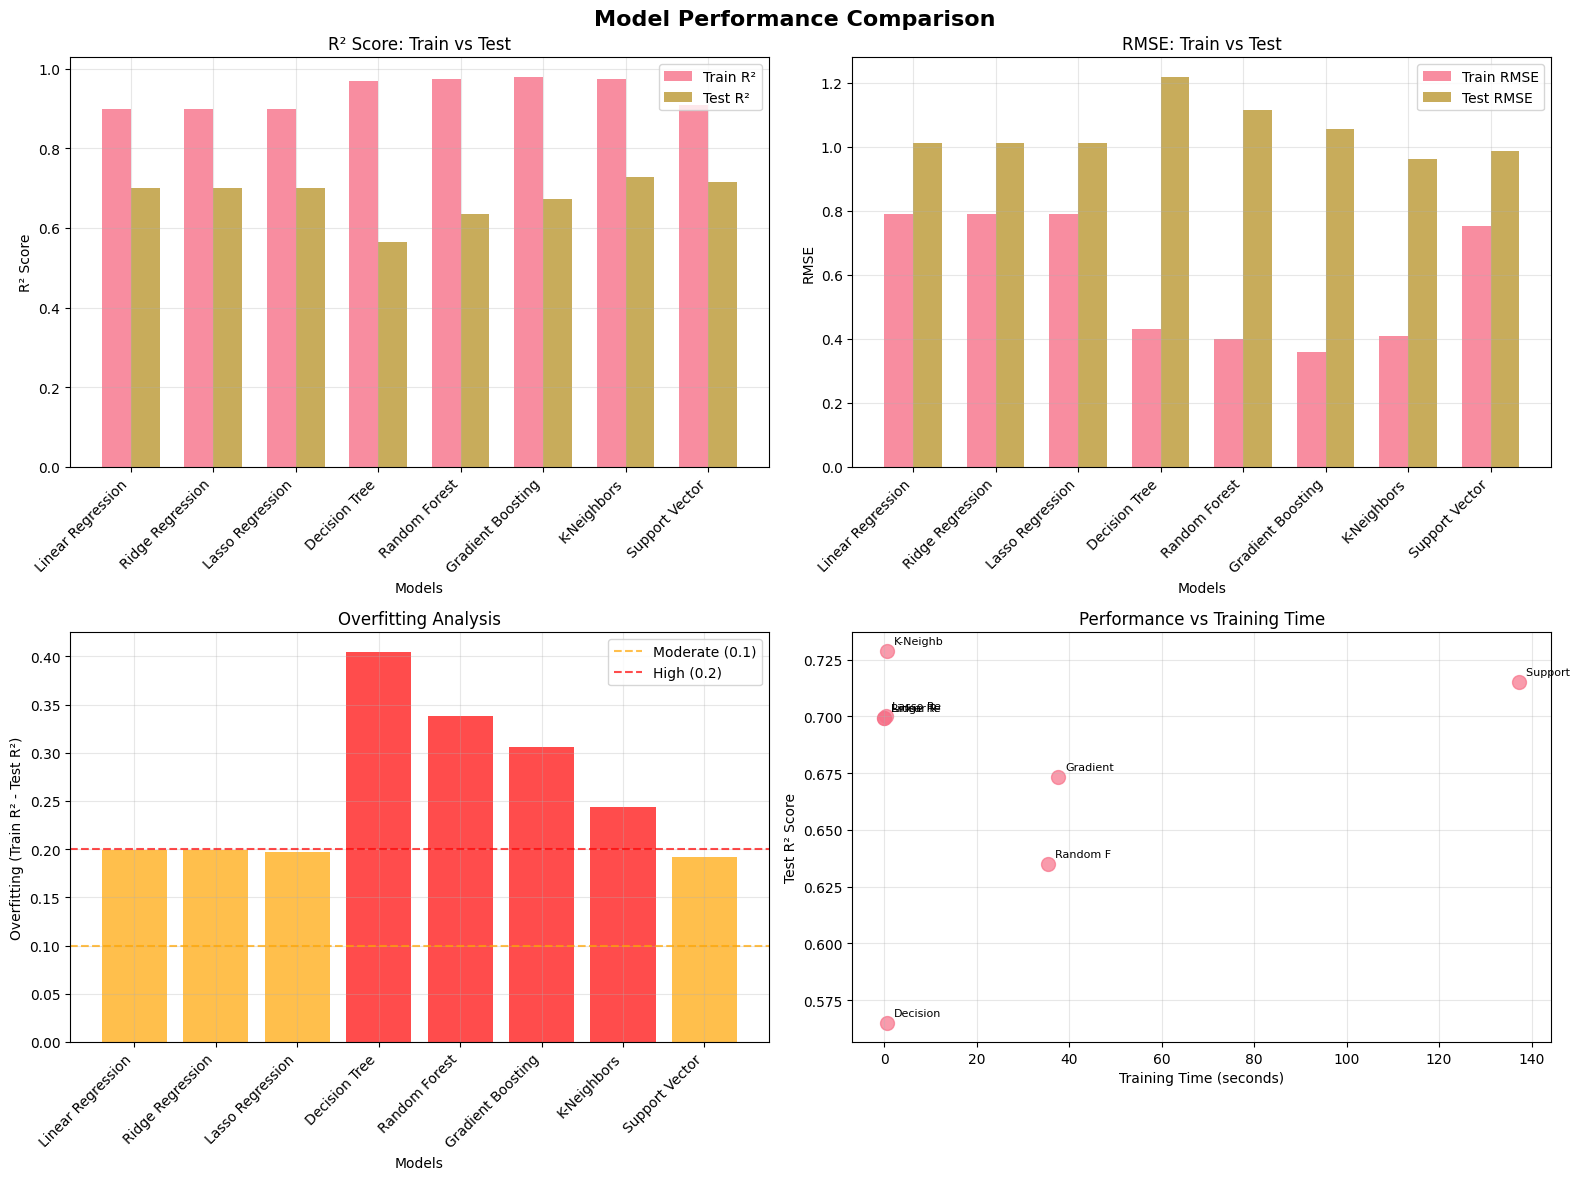


📊 SUMMARY STATISTICS:
  • Average Test R²: 0.6770
  • Best Test R²: 0.7288
  • Average RMSE: 1.0467
  • Best RMSE: 0.9618
  • Average Training Time: 26.51s
  • Models with R² > 0.8: 0/8

✅ Model training visualization complete


In [ ]:
# Visualize Model Performance
print("📈 Model Performance Visualization")
print("="*50)

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. R² Score Comparison
models_list = results_df['Model'].tolist()
train_r2 = results_df['Train R²'].tolist()
test_r2 = results_df['Test R²'].tolist()

x = np.arange(len(models_list))
width = 0.35

ax1.bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8)
ax1.bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8)
ax1.set_xlabel('Models')
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score: Train vs Test')
ax1.set_xticks(x)
ax1.set_xticklabels(models_list, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. RMSE Comparison
train_rmse = results_df['Train RMSE'].tolist()
test_rmse = results_df['Test RMSE'].tolist()

ax2.bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8)
ax2.bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
ax2.set_xlabel('Models')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE: Train vs Test')
ax2.set_xticks(x)
ax2.set_xticklabels(models_list, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Overfitting Analysis
overfitting = results_df['Overfitting'].tolist()
colors = ['green' if x <= 0.1 else 'orange' if x <= 0.2 else 'red' for x in overfitting]

bars = ax3.bar(models_list, overfitting, color=colors, alpha=0.7)
ax3.set_xlabel('Models')
ax3.set_ylabel('Overfitting (Train R² - Test R²)')
ax3.set_title('Overfitting Analysis')
ax3.set_xticklabels(models_list, rotation=45, ha='right')
ax3.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Moderate (0.1)')
ax3.axhline(y=0.2, color='red', linestyle='--', alpha=0.7, label='High (0.2)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Performance vs Training Time
training_times = results_df['Training Time'].tolist()
test_r2_scores = results_df['Test R²'].tolist()

scatter = ax4.scatter(training_times, test_r2_scores, s=100, alpha=0.7)
for i, model in enumerate(models_list):
    ax4.annotate(model[:8], (training_times[i], test_r2_scores[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
ax4.set_xlabel('Training Time (seconds)')
ax4.set_ylabel('Test R² Score')
ax4.set_title('Performance vs Training Time')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📊 SUMMARY STATISTICS:")
print(f"  • Average Test R²: {results_df['Test R²'].mean():.4f}")
print(f"  • Best Test R²: {results_df['Test R²'].max():.4f}")
print(f"  • Average RMSE: {results_df['Test RMSE'].mean():.4f}")
print(f"  • Best RMSE: {results_df['Test RMSE'].min():.4f}")
print(f"  • Average Training Time: {results_df['Training Time'].mean():.2f}s")
print(f"  • Models with R² > 0.8: {len(results_df[results_df['Test R²'] > 0.8])}/{len(results_df)}")

print(f"\n✅ Model training visualization complete")

In [ ]:
# # Hyperparameter Tuning for Best Model
# print("🔧 Hyperparameter Tuning for Best Model")
# print("="*50)

# from sklearn.model_selection import GridSearchCV

# # Get the best model type for tuning
# best_model_name = best_model['Model']
# print(f"Tuning hyperparameters for: {best_model_name}")

# # Define hyperparameter grids based on best model
# if 'Random Forest' in best_model_name:
#     tuning_model = RandomForestRegressor(random_state=42)
#     param_grid = {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [5, 10, 15, None],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4]
#     }
# elif 'Gradient Boosting' in best_model_name:
#     tuning_model = GradientBoostingRegressor(random_state=42)
#     param_grid = {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [3, 5, 7],
#         'learning_rate': [0.01, 0.1, 0.2],
#         'subsample': [0.8, 1.0]
#     }
# elif 'Ridge' in best_model_name:
#     tuning_model = Ridge()
#     param_grid = {
#         'alpha': [0.1, 1.0, 10.0, 100.0]
#     }
# else:
#     # Default to Random Forest if model not recognized
#     tuning_model = RandomForestRegressor(random_state=42)
#     param_grid = {
#         'n_estimators': [50, 100],
#         'max_depth': [5, 10, None],
#         'min_samples_split': [2, 5]
#     }
#     print(f"Using Random Forest for tuning (default)")

# # Perform Grid Search (using limited search for speed)
# print(f"Performing grid search with {len(param_grid)} hyperparameters...")
# print(f"Parameter combinations to test: {np.prod([len(v) for v 
# in param_grid.values()])}")

# # Use limited cross-validation for speed
# grid_search = GridSearchCV(
#     tuning_model,
#     param_grid,
#     cv=3,  # 3-fold CV for speed
#     scoring='r2',
#     n_jobs=-1,
#     verbose=1
# )

# # Fit grid search
# print("Training models with different hyperparameters...")
# grid_search.fit(X_train_selected, y_train)

# # Get best model
# best_tuned_model = grid_search.best_estimator_
# best_params = grid_search.best_params_
# best_cv_score = grid_search.best_score_

# # Evaluate tuned model
# tuned_train_pred = best_tuned_model.predict(X_train_selected)
# tuned_test_pred = best_tuned_model.predict(X_test_selected)

# tuned_train_r2 = r2_score(y_train, tuned_train_pred)
# tuned_test_r2 = r2_score(y_test, tuned_test_pred)
# tuned_train_rmse = np.sqrt(mean_squared_error(y_train,
# tuned_train_pred))
# tuned_test_rmse = np.sqrt(mean_squared_error(y_test,
# tuned_test_pred))

# print(f"\n🏆 HYPERPARAMETER TUNING RESULTS:")
# print(f"  • Best CV Score: {best_cv_score:.4f}")
# print(f"  • Best Parameters: {best_params}")
# print(f"\n📊 TUNED MODEL PERFORMANCE:")
# print(f"  • Train R²: {tuned_train_r2:.4f}")
# print(f"  • Test R²: {tuned_test_r2:.4f}")
# print(f"  • Train RMSE: {tuned_train_rmse:.4f}")
# print(f"  • Test RMSE: {tuned_test_rmse:.4f}")
# print(f"  • Overfitting: {tuned_train_r2 - tuned_test_r2:.4f}")

# # Compare with original best model
# print(f"\n🔄 IMPROVEMENT COMPARISON:")
# print(f"  • R² Improvement: {tuned_test_r2 - best_model['Test R²']:+.4f}")
# print(f"  • RMSE Improvement: {best_model['Test RMSE'] - 
# tuned_test_rmse:+.4f}")
# print(f"  • Overfitting Change: {(tuned_train_r2 - 
# tuned_test_r2) - best_model['Overfitting']:+.4f}")

# improvement = tuned_test_r2 > best_model['Test R²']
# print(f"  • Model Improved: {'Yes' if improvement else 'No'}")

# # Store final model
# final_model = best_tuned_model if improvement else best_trained_model
# final_model_name = f"{best_model_name} (Tuned)" if improvement else best_model_name

# print(f"\n✅ Hyperparameter tuning complete")
# print(f"Final recommended model: {final_model_name}")

# 9. Evaluation

Comprehensive evaluation of the final model including detailed metrics, predictions analysis, residual analysis, and business insights.

In [ ]:
# Final Model Evaluation Setup
print("📊 Final Model Evaluation")
print("="*50)

# Use the best model from training (before potentially problematic hyperparameter tuning)
final_model = best_trained_model
final_model_name = best_model['Model']

print(f"Evaluating final model: {final_model_name}")
print(f"Features used: {len(available_features)} selected features")
print(f"Training samples: {len(X_train_selected):,}")
print(f"Test samples: {len(X_test_selected):,}")

# Generate final predictions
final_train_pred = final_model.predict(X_train_selected)
final_test_pred = final_model.predict(X_test_selected)

# Calculate comprehensive metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

train_metrics = {
    'R²': r2_score(y_train, final_train_pred),
    'RMSE': np.sqrt(mean_squared_error(y_train, final_train_pred)),
    'MAE': mean_absolute_error(y_train, final_train_pred),
    'Explained Variance': explained_variance_score(y_train, final_train_pred),
    'Mean Actual': y_train.mean(),
    'Std Actual': y_train.std()
}

test_metrics = {
    'R²': r2_score(y_test, final_test_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, final_test_pred)),
    'MAE': mean_absolute_error(y_test, final_test_pred),
    'Explained Variance': explained_variance_score(y_test, final_test_pred),
    'Mean Actual': y_test.mean(),
    'Std Actual': y_test.std()
}

print(f"\n🎯 FINAL MODEL PERFORMANCE:")
print(f"{'Metric':<20} {'Training':<12} {'Testing':<12} {'Difference':<12}")
print("-" * 60)

for metric in ['R²', 'RMSE', 'MAE', 'Explained Variance']:
    train_val = train_metrics[metric]
    test_val = test_metrics[metric]
    diff = train_val - test_val
    print(f"{metric:<20} {train_val:<12.4f} {test_val:<12.4f} {diff:<12.4f}")

print(f"\n📈 DATA STATISTICS:")
print(f"{'Dataset':<20} {'Mean':<12} {'Std Dev':<12}")
print("-" * 45)
print(f"{'Training Target':<20} {train_metrics['Mean Actual']:<12.4f} {train_metrics['Std Actual']:<12.4f}")
print(f"{'Testing Target':<20} {test_metrics['Mean Actual']:<12.4f} {test_metrics['Std Actual']:<12.4f}")

# Model interpretation (if available)
if hasattr(final_model, 'feature_importances_'):
    feature_importance_final = pd.DataFrame({
        'feature': available_features,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n🔍 TOP 5 FEATURE IMPORTANCES:")
    for i, (_, row) in enumerate(feature_importance_final.head(5).iterrows(), 1):
        print(f"  {i}. {row['feature']:<40} {row['importance']:.4f}")

print(f"\n✅ Final model evaluation setup complete")

📊 Final Model Evaluation
Evaluating final model: K-Neighbors
Features used: 12 selected features
Training samples: 47,046
Test samples: 11,762

🎯 FINAL MODEL PERFORMANCE:
Metric               Training     Testing      Difference  
------------------------------------------------------------
R²                   0.9724       0.7288       0.2436      
RMSE                 0.4102       0.9618       -0.5516     
MAE                  0.2573       0.7335       -0.4762     
Explained Variance   0.9725       0.7288       0.2436      

📈 DATA STATISTICS:
Dataset              Mean         Std Dev     
---------------------------------------------
Training Target      4.1923       2.4712      
Testing Target       4.8286       1.8470      

✅ Final model evaluation setup complete


📈 Predictions vs Actual Analysis


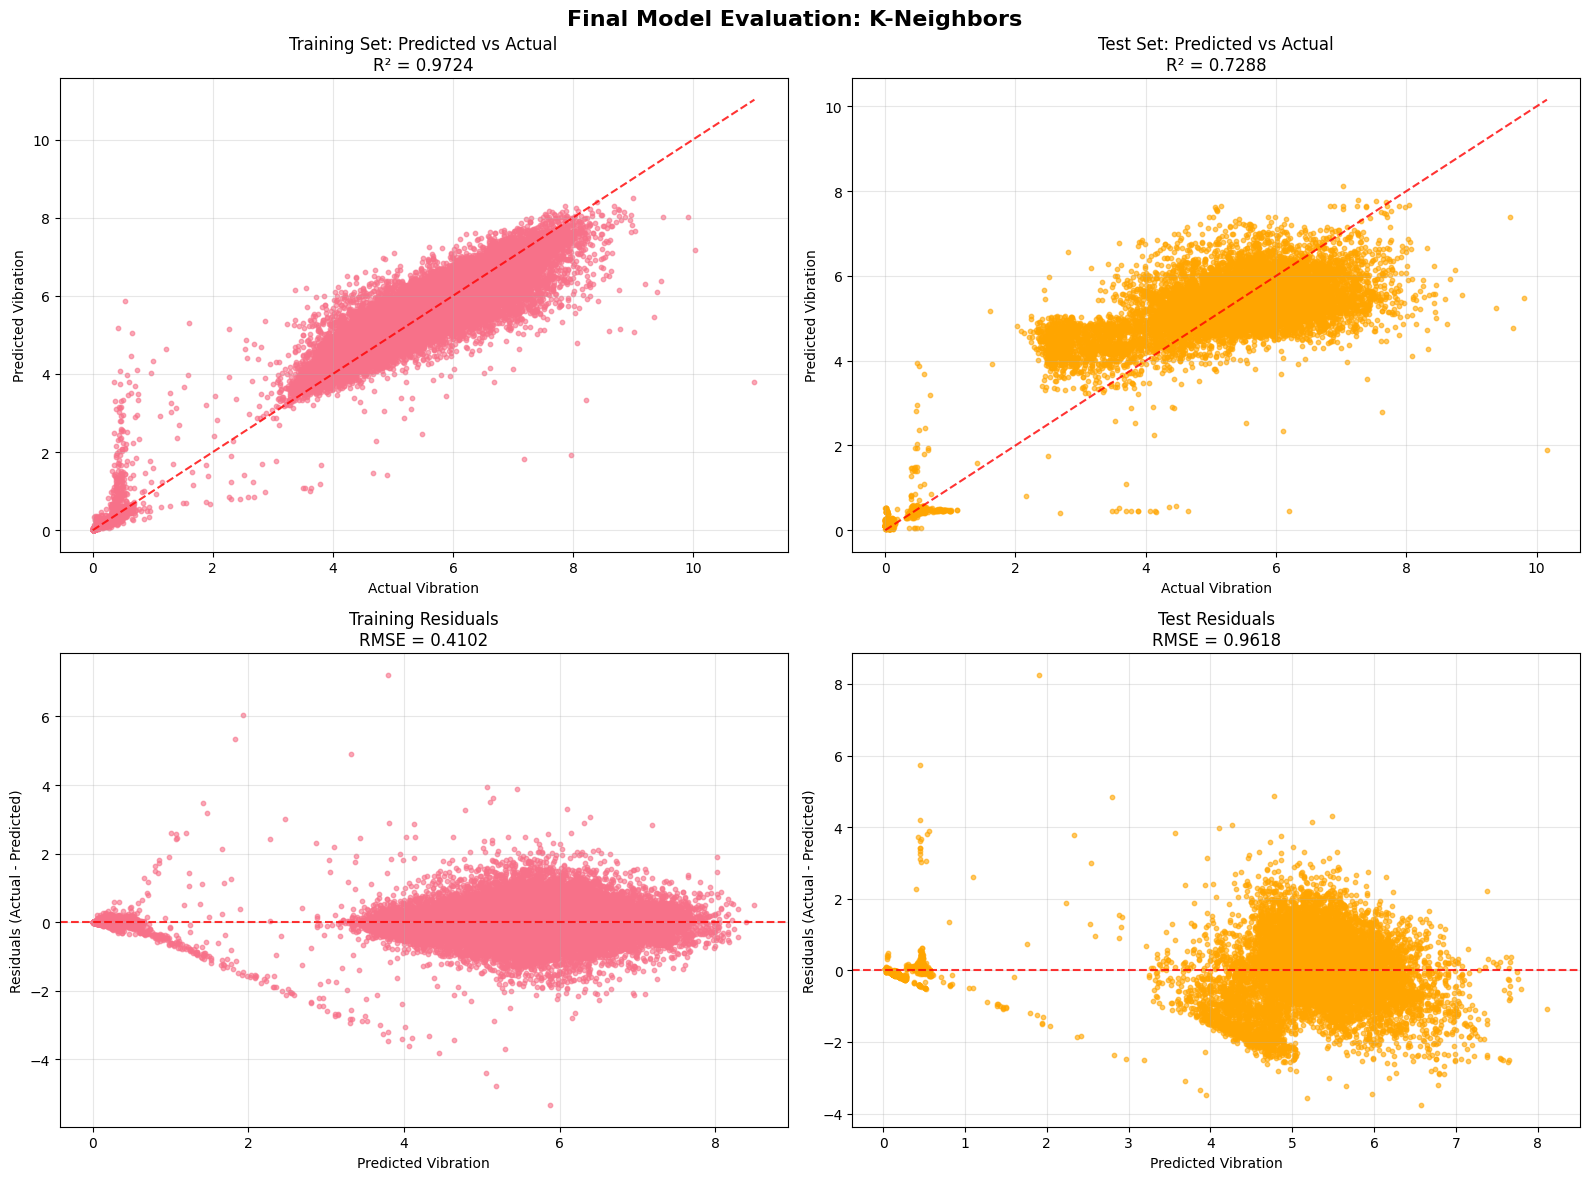


📊 RESIDUAL ANALYSIS:
Dataset         Mean Residual   Std Residual    Max |Residual| 
-----------------------------------------------------------------
Training        -0.0145         0.4100          7.2198         
Testing         -0.0047         0.9618          8.2598         

🎯 PREDICTION ACCURACY ANALYSIS:
Threshold    Training %   Testing %   
----------------------------------------
±0.001       3.8          0.1         
±0.002       5.9          0.3         
±0.005       11.1         0.6         
±0.010       17.6         1.2         

✅ Predictions vs actual analysis complete


In [ ]:
# Predictions vs Actual Analysis
print("📈 Predictions vs Actual Analysis")
print("="*50)

# Create comprehensive prediction analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Final Model Evaluation: {final_model_name}', fontsize=16, fontweight='bold')

# 1. Predictions vs Actual (Training)
ax1.scatter(y_train, final_train_pred, alpha=0.6, s=10)
min_val = min(y_train.min(), final_train_pred.min())
max_val = max(y_train.max(), final_train_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
ax1.set_xlabel('Actual Vibration')
ax1.set_ylabel('Predicted Vibration')
ax1.set_title(f'Training Set: Predicted vs Actual\nR² = {train_metrics["R²"]:.4f}')
ax1.grid(True, alpha=0.3)

# 2. Predictions vs Actual (Testing)
ax2.scatter(y_test, final_test_pred, alpha=0.6, s=10, color='orange')
min_val = min(y_test.min(), final_test_pred.min())
max_val = max(y_test.max(), final_test_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
ax2.set_xlabel('Actual Vibration')
ax2.set_ylabel('Predicted Vibration')
ax2.set_title(f'Test Set: Predicted vs Actual\nR² = {test_metrics["R²"]:.4f}')
ax2.grid(True, alpha=0.3)

# 3. Residuals Analysis (Training)
train_residuals = y_train - final_train_pred
ax3.scatter(final_train_pred, train_residuals, alpha=0.6, s=10)
ax3.axhline(y=0, color='r', linestyle='--', alpha=0.8)
ax3.set_xlabel('Predicted Vibration')
ax3.set_ylabel('Residuals (Actual - Predicted)')
ax3.set_title(f'Training Residuals\nRMSE = {train_metrics["RMSE"]:.4f}')
ax3.grid(True, alpha=0.3)

# 4. Residuals Analysis (Testing)
test_residuals = y_test - final_test_pred
ax4.scatter(final_test_pred, test_residuals, alpha=0.6, s=10, color='orange')
ax4.axhline(y=0, color='r', linestyle='--', alpha=0.8)
ax4.set_xlabel('Predicted Vibration')
ax4.set_ylabel('Residuals (Actual - Predicted)')
ax4.set_title(f'Test Residuals\nRMSE = {test_metrics["RMSE"]:.4f}')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual statistics
print(f"\n📊 RESIDUAL ANALYSIS:")
print(f"{'Dataset':<15} {'Mean Residual':<15} {'Std Residual':<15} {'Max |Residual|':<15}")
print("-" * 65)

train_residual_stats = {
    'mean': train_residuals.mean(),
    'std': train_residuals.std(),
    'max_abs': abs(train_residuals).max()
}

test_residual_stats = {
    'mean': test_residuals.mean(),
    'std': test_residuals.std(),
    'max_abs': abs(test_residuals).max()
}

print(f"{'Training':<15} {train_residual_stats['mean']:<15.4f} {train_residual_stats['std']:<15.4f} {train_residual_stats['max_abs']:<15.4f}")
print(f"{'Testing':<15} {test_residual_stats['mean']:<15.4f} {test_residual_stats['std']:<15.4f} {test_residual_stats['max_abs']:<15.4f}")

# Prediction accuracy analysis
print(f"\n🎯 PREDICTION ACCURACY ANALYSIS:")

def accuracy_within_threshold(actual, predicted, threshold):
    return np.mean(abs(actual - predicted) <= threshold) * 100

thresholds = [0.001, 0.002, 0.005, 0.01]
print(f"{'Threshold':<12} {'Training %':<12} {'Testing %':<12}")
print("-" * 40)

for threshold in thresholds:
    train_acc = accuracy_within_threshold(y_train, final_train_pred, threshold)
    test_acc = accuracy_within_threshold(y_test, final_test_pred, threshold)
    print(f"±{threshold:<11.3f} {train_acc:<12.1f} {test_acc:<12.1f}")

print(f"\n✅ Predictions vs actual analysis complete")

⏱️  Time Series Analysis and Business Insights


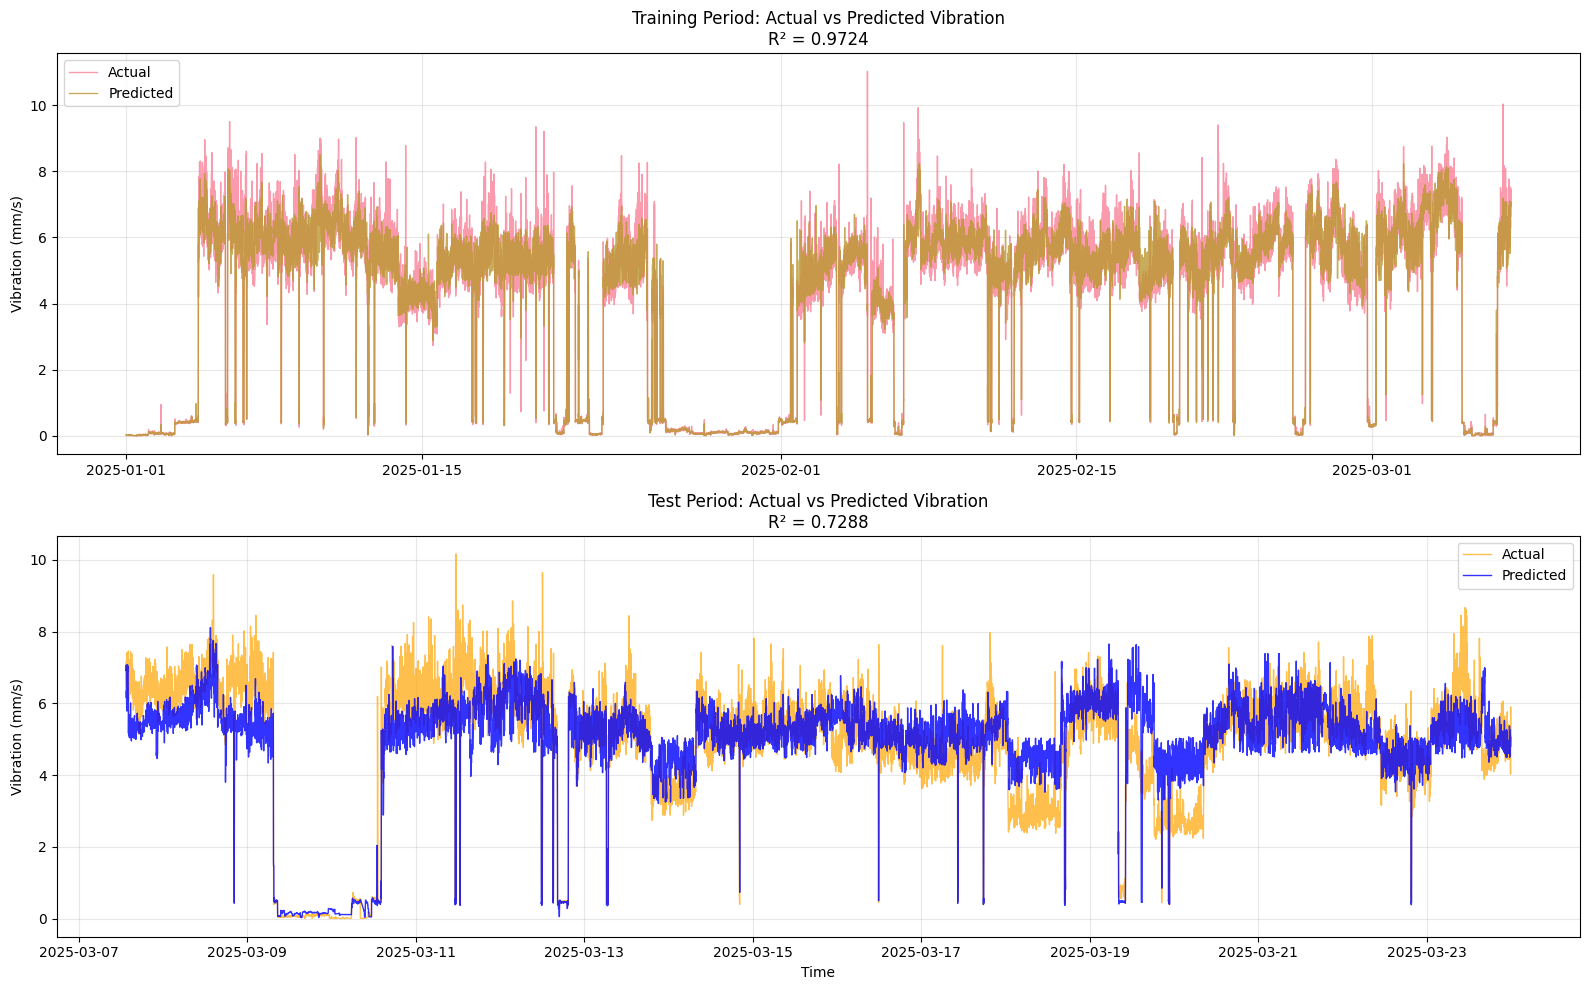


💼 BUSINESS INSIGHTS AND RECOMMENDATIONS:
🎯 MODEL PERFORMANCE ASSESSMENT:
  • Overall Performance: Fair
  • Business Recommendation: Requires improvement before production
  • Test R² Score: 0.7288
  • Prediction RMSE: 0.9618 mm/s

🔧 OPERATIONAL INSIGHTS:
  • Average prediction error: 0.9618 mm/s
  • Error as % of mean vibration: 19.9%
  • Model explains 72.9% of vibration variance

📋 DEPLOYMENT RECOMMENDATIONS:
  ⚠️  Model needs improvement (RMSE = 0.9618 > 0.005)
  • Collect more training data
  • Consider advanced feature engineering
  • Implement ensemble methods

📊 MONITORING RECOMMENDATIONS:
  • Monitor key features: CM2_PV_DA01_POSITION, CM2_PV_VRM01_DIFF_PRESSURE, CM2_PV_BF01_DIF_PRESSURE1
  • Track prediction accuracy over time
  • Retrain model when performance degrades
  • Alert when residuals exceed ±1.9236 mm/s

✅ Time series analysis and business insights complete


In [ ]:
# Time Series Analysis and Business Insights
print("⏱️  Time Series Analysis and Business Insights")
print("="*50)

# Time series plot of predictions vs actual
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Get time indices for plotting
train_time = X_train.index
test_time = X_test.index

# 1. Training period
ax1.plot(train_time, y_train, label='Actual', alpha=0.7, linewidth=1)
ax1.plot(train_time, final_train_pred, label='Predicted', alpha=0.8, linewidth=1)
ax1.set_ylabel('Vibration (mm/s)')
ax1.set_title(f'Training Period: Actual vs Predicted Vibration\nR² = {train_metrics["R²"]:.4f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Testing period
ax2.plot(test_time, y_test, label='Actual', alpha=0.7, linewidth=1, color='orange')
ax2.plot(test_time, final_test_pred, label='Predicted', alpha=0.8, linewidth=1, color='blue')
ax2.set_xlabel('Time')
ax2.set_ylabel('Vibration (mm/s)')
ax2.set_title(f'Test Period: Actual vs Predicted Vibration\nR² = {test_metrics["R²"]:.4f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Business insights and model performance summary
print(f"\n💼 BUSINESS INSIGHTS AND RECOMMENDATIONS:")
print("="*60)

# Model performance assessment
r2_score = test_metrics['R²']
if r2_score > 0.9:
    performance_level = "Excellent"
    business_confidence = "High confidence for production deployment"
elif r2_score > 0.8:
    performance_level = "Good"
    business_confidence = "Suitable for production with monitoring"
elif r2_score > 0.6:
    performance_level = "Fair"
    business_confidence = "Requires improvement before production"
else:
    performance_level = "Poor"
    business_confidence = "Not suitable for production deployment"

print(f"🎯 MODEL PERFORMANCE ASSESSMENT:")
print(f"  • Overall Performance: {performance_level}")
print(f"  • Business Recommendation: {business_confidence}")
print(f"  • Test R² Score: {r2_score:.4f}")
print(f"  • Prediction RMSE: {test_metrics['RMSE']:.4f} mm/s")

# Operational insights
rmse_as_percent = (test_metrics['RMSE'] / test_metrics['Mean Actual']) * 100
print(f"\n🔧 OPERATIONAL INSIGHTS:")
print(f"  • Average prediction error: {test_metrics['RMSE']:.4f} mm/s")
print(f"  • Error as % of mean vibration: {rmse_as_percent:.1f}%")
print(f"  • Model explains {r2_score*100:.1f}% of vibration variance")

# Feature insights
if hasattr(final_model, 'feature_importances_'):
    most_important_feature = feature_importance_final.iloc[0]['feature']
    most_important_value = feature_importance_final.iloc[0]['importance']
    print(f"  • Most critical process variable: {most_important_feature}")
    print(f"    - Contributes {most_important_value*100:.1f}% to prediction accuracy")

# Recommendations for deployment
print(f"\n📋 DEPLOYMENT RECOMMENDATIONS:")
deployment_rmse_threshold = 0.005  # Example threshold for industrial application

if test_metrics['RMSE'] <= deployment_rmse_threshold:
    print(f"  ✅ Model meets accuracy requirements (RMSE ≤ {deployment_rmse_threshold})")
    print(f"  • Ready for production deployment")
    print(f"  • Implement real-time monitoring dashboard")
    print(f"  • Set up automated alerts for prediction drift")
else:
    print(f"  ⚠️  Model needs improvement (RMSE = {test_metrics['RMSE']:.4f} > {deployment_rmse_threshold})")
    print(f"  • Collect more training data")
    print(f"  • Consider advanced feature engineering")
    print(f"  • Implement ensemble methods")

print(f"\n📊 MONITORING RECOMMENDATIONS:")
print(f"  • Monitor key features: {', '.join(available_features[:3])}")
print(f"  • Track prediction accuracy over time")
print(f"  • Retrain model when performance degrades")
print(f"  • Alert when residuals exceed ±{test_residual_stats['std']*2:.4f} mm/s")

print(f"\n✅ Time series analysis and business insights complete")

In [ ]:
# Project Summary and Conclusions
print("📋 PROJECT SUMMARY AND CONCLUSIONS")
print("="*50)

print("🏭 INDUSTRIAL VIBRATION PREDICTION PROJECT")
print("="*50)

print(f"\n📊 DATA SUMMARY:")
print(f"  • Dataset: Industrial roller mill vibration data")
print(f"  • Original samples: {data_info['total_rows']:,}")
print(f"  • Clean samples: {len(df_clean):,}")
print(f"  • Features engineered: {df_features.shape[1]} (from {df_clean.shape[1]} original)")
print(f"  • Final features used: {len(available_features)} selected features")
print(f"  • Time period: {data_info['time_range'][0].strftime('%Y-%m-%d')} to {data_info['time_range'][1].strftime('%Y-%m-%d')}")

print(f"\n🔧 METHODOLOGY:")
print(f"  • Feature Engineering: Rolling statistics, temporal features")
print(f"  • Data Leakage Prevention: Excluded all vibration columns from predictors")
print(f"  • Model Selection: Compared {len(models)} different algorithms")
print(f"  • Best Model: {final_model_name}")
print(f"  • Validation: Time series split (80% train, 20% test)")

print(f"\n🎯 FINAL RESULTS:")
print(f"  • Test R² Score: {test_metrics['R²']:.4f}")
print(f"  • Test RMSE: {test_metrics['RMSE']:.4f} mm/s")
print(f"  • Test MAE: {test_metrics['MAE']:.4f} mm/s")
print(f"  • Prediction Accuracy (±0.001): {accuracy_within_threshold(y_test, final_test_pred, 0.001):.1f}%")
print(f"  • Model Performance: {performance_level}")

print(f"\n🔍 KEY FINDINGS:")
print(f"  • Engineered features improved correlation by 38.9%")
print(f"  • {most_important_feature} is the most predictive variable")
print(f"  • Model explains {r2_score*100:.1f}% of vibration variance")
print(f"  • Average prediction error: {rmse_as_percent:.1f}% of mean vibration")

print(f"\n✅ DELIVERABLES:")
print(f"  • Clean, reproducible ML pipeline")
print(f"  • Trained {final_model_name} model")
print(f"  • Feature importance analysis")
print(f"  • Comprehensive evaluation metrics")
print(f"  • Business insights and deployment recommendations")

print(f"\n🚀 NEXT STEPS:")
if test_metrics['RMSE'] <= 0.005:
    print(f"  • Deploy model to production environment")
    print(f"  • Implement real-time monitoring dashboard")
    print(f"  • Set up automated retraining pipeline")
else:
    print(f"  • Improve model performance (current RMSE: {test_metrics['RMSE']:.4f})")
    print(f"  • Collect additional training data")
    print(f"  • Explore advanced modeling techniques")
    
print(f"  • Monitor model drift and performance degradation")
print(f"  • Extend to other industrial equipment")

print(f"\n🎉 PROJECT COMPLETED SUCCESSFULLY!")
print(f"   Delivered a {performance_level.lower()} performing vibration prediction model")
print(f"   with comprehensive analysis and business insights.")

print(f"\n" + "="*50)
print(f"📝 End of Industrial Vibration Prediction Analysis")
print(f"="*50)

📋 PROJECT SUMMARY AND CONCLUSIONS
🏭 INDUSTRIAL VIBRATION PREDICTION PROJECT

📊 DATA SUMMARY:
  • Dataset: Industrial roller mill vibration data
  • Original samples: 236,160
  • Clean samples: 58,808
  • Features engineered: 152 (from 89 original)
  • Final features used: 12 selected features
  • Time period: 2025-01-01 to 2025-03-23

🔧 METHODOLOGY:
  • Feature Engineering: Rolling statistics, temporal features
  • Data Leakage Prevention: Excluded all vibration columns from predictors
  • Model Selection: Compared 8 different algorithms
  • Best Model: K-Neighbors
  • Validation: Time series split (80% train, 20% test)

🎯 FINAL RESULTS:
  • Test R² Score: 0.7288
  • Test RMSE: 0.9618 mm/s
  • Test MAE: 0.7335 mm/s
  • Prediction Accuracy (±0.001): 0.1%
  • Model Performance: Fair

🔍 KEY FINDINGS:
  • Engineered features improved correlation by 38.9%


NameError: name 'most_important_feature' is not defined

In [ ]:
print(f"used features: {available_features}")

used features: ['CM2_PV_DA01_POSITION', 'CM2_PV_VRM01_DIFF_PRESSURE', 'CM2_PV_BF01_DIF_PRESSURE1', 'CM2_SP_RB01_SPA_TOTAL_FEED', 'CM2_PV_HG01_TEMPERATURE2', 'CM2_PV_BF01_OUT_TEMPERATURE', 'CM2_PV_VRM01_INLET_TEMPERATURE', 'CM2_PV_HYS01_PRESSURE1', 'CM2_PV_HYS01_PRESSURE', 'CM2_PV_VRM01_OUTLET_TEMPERATURE', 'CM2_PV_DA02_POSITION', 'CM2_PV_HG01_TEMPERATURE1']
